In [10]:
import time
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import random
import os
import sys
import h5py
import os
from scipy import signal
import copy
import pyfonts

import matplotlib.font_manager
font_names = [f.name for f in matplotlib.font_manager.fontManager.ttflist]
# Print unique sorted names to find the exact name of the font you want to use
print(sorted(set(font_names)))
font = pyfonts.load_google_font("Average Sans")

['Agency FB', 'Algerian', 'Arial', 'Arial Rounded MT Bold', 'Bahnschrift', 'Baskerville Old Face', 'Bauhaus 93', 'Bell MT', 'Berlin Sans FB', 'Berlin Sans FB Demi', 'Bernard MT Condensed', 'Blackadder ITC', 'Bodoni MT', 'Book Antiqua', 'Bookman Old Style', 'Bookshelf Symbol 7', 'Bradley Hand ITC', 'Britannic Bold', 'Broadway', 'Brush Script MT', 'Calibri', 'Californian FB', 'Calisto MT', 'Cambria', 'Candara', 'Castellar', 'Centaur', 'Century', 'Century Gothic', 'Century Schoolbook', 'Chiller', 'Colonna MT', 'Comic Sans MS', 'Consolas', 'Constantia', 'Cooper Black', 'Copperplate Gothic Bold', 'Copperplate Gothic Light', 'Corbel', 'Courier New', 'Curlz MT', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif Display', 'Dubai', 'Ebrima', 'Edwardian Script ITC', 'Elephant', 'Engravers MT', 'Eras Bold ITC', 'Eras Demi ITC', 'Eras Light ITC', 'Eras Medium ITC', 'Felix Titling', 'Font Awesome 5 Brands', 'Font Awesome 5 Free Regular', 'Font Awesome 5 Free So

In [55]:
#Set global plotting parameters
mpl.rcParams['agg.path.chunksize'] = 10000
mpl.rcParams['figure.dpi'] = 600

font = pyfonts.load_google_font("Average Sans")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ['Sitka']#, "DejaVu Sans", "Liberation Sans", "Verdana", "Arial", "Helvetica", "sans-serif"]
SIZE_DEFAULT = 10
plt.rcParams["font.size"] = SIZE_DEFAULT
plt.rcParams["axes.titlesize"] = SIZE_DEFAULT + 6
plt.rcParams["axes.labelsize"] = SIZE_DEFAULT + 6
plt.rcParams["xtick.labelsize"] = SIZE_DEFAULT
plt.rcParams["ytick.labelsize"] = SIZE_DEFAULT

fig_width = 6  # inches
fig_height = 3  # inches
plt.rcParams["figure.figsize"] = (fig_width, fig_height)

In [56]:

def makearray(startfreq1,startfreq2,separation,size,dim2):
    '''
    makearray will generate a list of points to use as the final array locations
    The lower frequencies in the array are defined by startfreq1 and startfreq2
    Separation : float
        defines how far apart you want the array spots to be in MHz (note
     1 MHz ~ 70um)
    size : float 
        defines the number of points in the array
    dim2 : float
        defines how many rows will be in the array
    It will make a rectangular array with set number of rows and as many columns 
    as needed. It will half fill columns starting at the top for the final spots
    '''
    array = np.zeros((size,2))
    freq1 = startfreq1 - separation
    freq2 = startfreq2
    for i in range(size):
        
        if i%dim2 == 0:
            freq2 = startfreq2
            freq1 = freq1 + separation
            array[i,0] = freq1
            array[i,1] = freq2
        else:
            freq2 = freq2 + separation
            array[i,0] = freq1
            array[i,1] = freq2
            

    return array
        

# endpoints = makearray(22, 22, 1, 100, 6)
# endpoints = endpoints[:len(startpoints),:]

def optimalassignment(startpoints, endpoints):
    '''
    Matches the starting points to the ending points in a way that minimizes the 
    total distance of the differences between them
    
    Parameters
    ----------
    startpoints : 2d array of floats
        Array of all the starting points. In the format of number of points x 2
        to be a list of all the points (ch0 freq, ch1 freq)
    endpoints : 2d array of floats
        Array of all the ending points. In the format of number of points x 2
        to be a list of all the points (ch0 freq, ch1 freq)

    Returns
    -------
    xtravellines : 1d array of array of floats
        DESCRIPTION.
    ytravellines : TYPE
        DESCRIPTION.
    row_ind : TYPE
        DESCRIPTION.
    col_ind : TYPE
        DESCRIPTION.

    '''
    d = cdist(startpoints, endpoints)

    row_ind, col_ind = linear_sum_assignment(d)
    
    xtravellines = [ [] for i in range(len(startpoints)) ]
    ytravellines = [ [] for i in range(len(startpoints)) ]
    
    return xtravellines, ytravellines, row_ind, col_ind


def pathfinder(xtravellines, ytravellines, startpoints, endpoints, row_ind, col_ind, todrawlist):
    '''
    pathfinder takes in the starting points of the spheres and desired endpoints
    for the specified pairs
    It then will make direct lines between them

    Parameters
    ----------
    xtravellines : TYPE
        DESCRIPTION.
    ytravellines : TYPE
        DESCRIPTION.
    startpoints : TYPE
        DESCRIPTION.
    endpoints : TYPE
        DESCRIPTION.
    row_ind : TYPE
        DESCRIPTION.
    col_ind : TYPE
        DESCRIPTION.
    todrawlist : TYPE
        DESCRIPTION.

    Returns
    -------
    xtravellines : TYPE
        DESCRIPTION.
    ytravellines : TYPE
        DESCRIPTION.

    '''
    for i in todrawlist:
        
        #makes direct lines between the start and end points
        if np.abs(startpoints[row_ind[i]][0]-endpoints[col_ind[i]][0]) > np.abs(startpoints[row_ind[i]][1] - endpoints[col_ind[i]][1]):
            slope = (endpoints[col_ind[i]][1] - startpoints[row_ind[i]][1]) / (endpoints[col_ind[i]][0] - startpoints[row_ind[i]][0])
            
            if startpoints[row_ind[i]][0] > endpoints[col_ind[i]][0]:
                step = -0.05
                xsegment = np.arange(startpoints[row_ind[i]][0], endpoints[col_ind[i]][0]-step, step)
            else:
                step = 0.05
                xsegment = np.arange(startpoints[row_ind[i]][0], endpoints[col_ind[i]][0]+step, step)
            
            ysegment = slope * ( xsegment - startpoints[row_ind[i]][0] ) + startpoints[row_ind[i]][1]
            
        elif np.abs(startpoints[row_ind[i]][0]-endpoints[col_ind[i]][0]) == np.abs(startpoints[row_ind[i]][1] - endpoints[col_ind[i]][1]) == 0:
            xsegment = [ startpoints[row_ind[i]][0] ]
            ysegment = [ startpoints[row_ind[i]][1] ]
        else:
            slope = (endpoints[col_ind[i]][0] - startpoints[row_ind[i]][0]) / (endpoints[col_ind[i]][1] - startpoints[row_ind[i]][1])
            
            if startpoints[row_ind[i]][1] > endpoints[col_ind[i]][1]:
                step = -0.05
                ysegment = np.arange(startpoints[row_ind[i]][1], endpoints[col_ind[i]][1]-step, step)
            else:
                step = 0.05
                ysegment = np.arange(startpoints[row_ind[i]][1], endpoints[col_ind[i]][1]+step, step)
            
            xsegment = slope * ( ysegment - startpoints[row_ind[i]][1] ) + startpoints[row_ind[i]][0]
            
        ######################################################################
           
        # makes paths along straight lines and perfect diagonals (slope -1 or 1)
        # if startpoints[row_ind[i]][0] == endpoints[col_ind[i]][0]:
        #     xsegment = [ startpoints[row_ind[i]][0] ]
        # elif startpoints[row_ind[i]][0] > endpoints[col_ind[i]][0]:
        #     step = -0.05
        #     xsegment = np.arange(startpoints[row_ind[i]][0], endpoints[col_ind[i]][0]+step, step)
        # else:
        #     step = 0.05
        #     xsegment = np.arange(startpoints[row_ind[i]][0], endpoints[col_ind[i]][0]+step, step)
        
        # if startpoints[row_ind[i]][1] == endpoints[col_ind[i]][1]:
        #     ysegment = [ startpoints[row_ind[i]][1] ]
        # elif startpoints[row_ind[i]][1] > endpoints[col_ind[i]][1]:
        #     step = -0.05
        #     ysegment = np.arange(startpoints[row_ind[i]][1], endpoints[col_ind[i]][1]+step, step)
        # else:
        #     step = 0.05
        #     ysegment = np.arange(startpoints[row_ind[i]][1], endpoints[col_ind[i]][1]+step, step)
    
        # if len(xsegment) < len(ysegment):
        #     xsegment = np.pad(xsegment,(0,(len(ysegment)-len(xsegment))),'constant',constant_values=xsegment[-1])
        # if len(ysegment) < len(xsegment):
        #     ysegment = np.pad(ysegment,(0,(len(xsegment)-len(ysegment))),'constant',constant_values=ysegment[-1])
        
        
        ######################################################################
        #adds the endpoints to the end of the paths to ensure that it ends at the desired spots
        xsegment = np.append(xsegment,endpoints[col_ind[i]][0])
        ysegment = np.append(ysegment,endpoints[col_ind[i]][1])
        xsegment = np.round(xsegment, 4)
        ysegment = np.round(ysegment, 4)
        xtravellines[i] = xsegment
        ytravellines[i] = ysegment
    
    
    return xtravellines, ytravellines


def proximitycheck(xtravellines, ytravellines, row_ind, col_ind, swapenabled):
    '''
    
    '''
    
    alarm = False
    alreadyswappedlist = []
    counter = 0
    for i in range(max(len(a) for a in xtravellines)):
        xlocs=[]
        ylocs=[]
        for b in xtravellines:
            if i >= len(b):
                xlocs.append(b[-1])
            else:
                xlocs.append(b[i])
        for c in ytravellines:
            if i >= len(c):
                ylocs.append(c[-1])
            else:
                ylocs.append(c[i])
        
        
        for i1 in range(len(xlocs)):
            for i2 in range(len(xlocs)):
                distcheck = np.sqrt((xlocs[i2] - xlocs[i1])**2 + (ylocs[i2]-ylocs[i1])**2)
                if i1 != i2 and distcheck < 0.4 and (i1 not in alreadyswappedlist) and (i2 not in alreadyswappedlist):
                    alarm = True
                    #print("Pairs "+ str(i1) + ' and '+ str(i2) + " paths overlap")
                    if swapenabled == True:
                        swap1 = col_ind[i1]
                        swap2 = col_ind[i2]
                        col_ind[i1] = swap2
                        col_ind[i2] = swap1
                    alreadyswappedlist.append(i1)
                    alreadyswappedlist.append(i2)
                    counter = counter + 1
                    
    #print("There were " + str(counter) + " conflicts \n \n")                 
    return alarm, row_ind, col_ind, counter, alreadyswappedlist


# def polylinepaths(xtravellines, ytravellines, row_ind, col_ind, startpoints, endpoints):
#     mindist = 0.4
#     for i in range(max(len(a) for a in xtravellines)):
#         xlocs=[]
#         ylocs=[]
#         for b in xtravellines:
#             if i >= len(b):
#                 xlocs.append(b[-1])
#             else:
#                 xlocs.append(b[i])
#         for c in ytravellines:
#             if i >= len(c):
#                 ylocs.append(c[-1])
#             else:
#                 ylocs.append(c[i])
        
        
#         for i1 in range(len(xlocs)):
#             for i2 in range(len(xlocs)):
#                 distcheck = np.sqrt((xlocs[i2] - xlocs[i1])**2 + (ylocs[i2]-ylocs[i1])**2)
#                 if i1 != i2 and distcheck < mindist and (i1 not in alreadyfixed) and (i2 not in alreadyfixed):
                                        
#                     for i3 in (i1,i2):
#                         for i4 in (i1,i2):
#                             if i4 != i3:        
#                                 if ylocs[i3] > ylocs[i4]:
#                                     disp = (mindist - (ylocs[i3] - ylocs[i4]))/2
#                                     interpoint = [xlocs[i3],ylocs[i3]+disp]
#                                 elif ylocs[i3] < ylocs[i4]:
#                                     disp = (mindist + (ylocs[i3] - ylocs[i4]))/2
#                                     interpoint = [xlocs[i3],ylocs[i3]-disp]
                        
#                         if np.abs(startpoints[row_ind[i]][0]-endpoints[col_ind[i]][0]) > np.abs(startpoints[row_ind[i]][1] - endpoints[col_ind[i]][1]):
#                             slope = (endpoints[col_ind[i]][1] - startpoints[row_ind[i]][1]) / (endpoints[col_ind[i]][0] - startpoints[row_ind[i]][0])
                            
#                             if startpoints[row_ind[i]][0] > endpoints[col_ind[i]][0]:
#                                 step = -0.05
#                                 xsegment = np.arange(startpoints[row_ind[i]][0], endpoints[col_ind[i]][0]+step, step)
#                             else:
#                                 step = 0.05
#                                 xsegment = np.arange(startpoints[row_ind[i]][0], endpoints[col_ind[i]][0]+step, step)
                            
#                             ysegment = slope * ( xsegment - startpoints[row_ind[i]][0] ) + startpoints[row_ind[i]][1]
                            
#                         elif np.abs(startpoints[row_ind[i]][0]-endpoints[col_ind[i]][0]) == np.abs(startpoints[row_ind[i]][1] - endpoints[col_ind[i]][1]) == 0:
#                             xsegment = [ startpoints[row_ind[i]][0] ]
#                             ysegment = [ startpoints[row_ind[i]][1] ]
#                         else:
#                             slope = (endpoints[col_ind[i]][0] - startpoints[row_ind[i]][0]) / (endpoints[col_ind[i]][1] - startpoints[row_ind[i]][1])
                            
#                             if startpoints[row_ind[i]][1] > endpoints[col_ind[i]][1]:
#                                 step = -0.05
#                                 ysegment = np.arange(startpoints[row_ind[i]][1], endpoints[col_ind[i]][1]+step, step)
#                             else:
#                                 step = 0.05
#                                 ysegment = np.arange(startpoints[row_ind[i]][1], endpoints[col_ind[i]][1]+step, step)
                            
#                             xsegment = slope * ( ysegment - startpoints[row_ind[i]][1] ) + startpoints[row_ind[i]][0]



def delaypath(xtravellines, ytravellines, row_ind, col_ind, delaylist):
    '''
    '''
    
    mindist = 0.4
    alreadyfixed = []
    for i in range(max(len(a) for a in xtravellines)):
        
        xlocs=[]
        ylocs=[]
        
        for b in delaylist:
            if i >= len(xtravellines[b]):
                xlocs.append(xtravellines[b][-1])
            else:
                xlocs.append(xtravellines[b][i])
                
        for c in delaylist:
            if i >= len(ytravellines[c]):
                ylocs.append(ytravellines[c][-1])
            else:
                ylocs.append(ytravellines[c][i])
        
        
        for i1 in range(len(xlocs)):
            for i2 in range(len(xlocs)):
                distcheck = np.sqrt((xlocs[i2] - xlocs[i1])**2 + (ylocs[i2]-ylocs[i1])**2)
                if i1 != i2 and distcheck < mindist and (i1 not in alreadyfixed) and (i2 not in alreadyfixed):
                    if len(xtravellines[delaylist[i1]]) < len(xtravellines[delaylist[i2]]):
                        dchoice = delaylist[i1]
                        longer = delaylist[i2]
                    else:
                        dchoice = delaylist[i2]
                        longer = delaylist[i1]
                        
                    if i > len(xtravellines[dchoice]):
                        if 9 > len(xtravellines[dchoice]):
                            pos = -2
                        else:
                            pos = -10
                        #if performance is bad, change delaylength to just 10 for all cases
                        delaylength = (i - len(xtravellines[dchoice])) + 10
                    else:
                        pos = i-2
                        delaylength = 10
                        
                    xtest = np.concatenate((xtravellines[dchoice][:pos], [xtravellines[dchoice][pos]]*delaylength, xtravellines[dchoice][pos:]))
                    ytest = np.concatenate((ytravellines[dchoice][:pos], [ytravellines[dchoice][pos]]*delaylength, ytravellines[dchoice][pos:]))
                    #xtest = np.concatenate(([xtravellines[dchoice][0]]*30, xtravellines[dchoice]))
                    #ytest = np.concatenate(([ytravellines[dchoice][0]]*30, ytravellines[dchoice]))
                    delaysuccess = True
                    for k in range(len(xtravellines[longer])):
                        if k >= len(xtest):
                            distcheck2 = np.sqrt((xtest[-1] - xtravellines[longer][k])**2 + (ytest[-1]-ytravellines[longer][k])**2)
                        else:
                            distcheck2 = np.sqrt((xtest[k] - xtravellines[longer][k])**2 + (ytest[k]-ytravellines[longer][k])**2)
                        if distcheck2 < mindist:
                            delaysuccess = False
                    
                    if delaysuccess == True:
                        xtravellines[dchoice] = xtest
                        ytravellines[dchoice] = ytest
                    alreadyfixed.append(i1)
                    alreadyfixed.append(i2)
    return xtravellines, ytravellines


def doublecheck(alarm,xtravellines,ytravellines,row_ind,col_ind,startpoints, endpoints, redrawlist):
    '''
    
    '''
    
    for i in range(0,10):
    
        if alarm == True:
            xtravellines, ytravellines = pathfinder(xtravellines, ytravellines, startpoints, endpoints, row_ind, col_ind, redrawlist)
            alarm, row_ind, col_ind, counter, redrawlist = proximitycheck(xtravellines, ytravellines, row_ind, col_ind,True)

            fig,ax = plt.subplots(figsize=(3,3))
            for i in range(len(xtravellines)):
                lines = ax.plot(xtravellines[i], ytravellines[i],'--',zorder=1)
                plt.setp(lines, color='black')
                ax.plot(xtravellines[i][0], ytravellines[i][0], 'og',zorder=3)
                ax.plot(xtravellines[i][-1], ytravellines[i][-1], 'ob',zorder=4)

            for i in redrawlist:
                lines = ax.plot(xtravellines[i], ytravellines[i],'--',zorder=2)
                plt.setp(lines, color='red')
                ax.plot(xtravellines[i][0], ytravellines[i][0], 'og',zorder=3)
                ax.plot(xtravellines[i][-1], ytravellines[i][-1], 'ob',zorder=4)

            ax.set_xlim([19, 31])
            ax.set_ylim([19, 31])
            ax.set_xlabel('X Position')
            ax.set_ylabel('Y Position')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.show()

    trieddelay = False
    delaycounter = counter
    

    for i in range(0,3):
        if alarm == True:
            lastcounter = delaycounter
            trieddelay = True
            xtravellines, ytravellines = pathfinder(xtravellines, ytravellines, startpoints, endpoints, row_ind, col_ind, redrawlist)
            newxtravellines, newytravellines = delaypath(xtravellines, ytravellines, row_ind, col_ind, redrawlist)
            alarm, row_ind, col_ind, delaycounter, redrawlist = proximitycheck(newxtravellines, newytravellines, row_ind, col_ind, True)
            if delaycounter < lastcounter:
                xtravellines = newxtravellines
                ytravellines = newytravellines
            else:
                delaycounter = lastcounter
            
                fig,ax = plt.subplots(figsize=(3,3))
                for i in range(len(xtravellines)):
                    lines = ax.plot(xtravellines[i], ytravellines[i],'--',zorder=1)
                    plt.setp(lines, color='black')
                    ax.plot(xtravellines[i][0], ytravellines[i][0], 'og',zorder=3)
                    ax.plot(xtravellines[i][-1], ytravellines[i][-1], 'ob',zorder=4)

                for i in redrawlist:
                    lines = ax.plot(xtravellines[i], ytravellines[i],'--',zorder=2)
                    plt.setp(lines, color='purple')
                    ax.plot(xtravellines[i][0], ytravellines[i][0], 'og',zorder=3)
                    ax.plot(xtravellines[i][-1], ytravellines[i][-1], 'ob',zorder=4)

                ax.set_xlim([19, 31])
                ax.set_ylim([19, 31])
                ax.set_xlabel('X Position')
                ax.set_ylabel('Y Position')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                plt.show()
    return xtravellines, ytravellines, row_ind, col_ind, counter, trieddelay, delaycounter, redrawlist


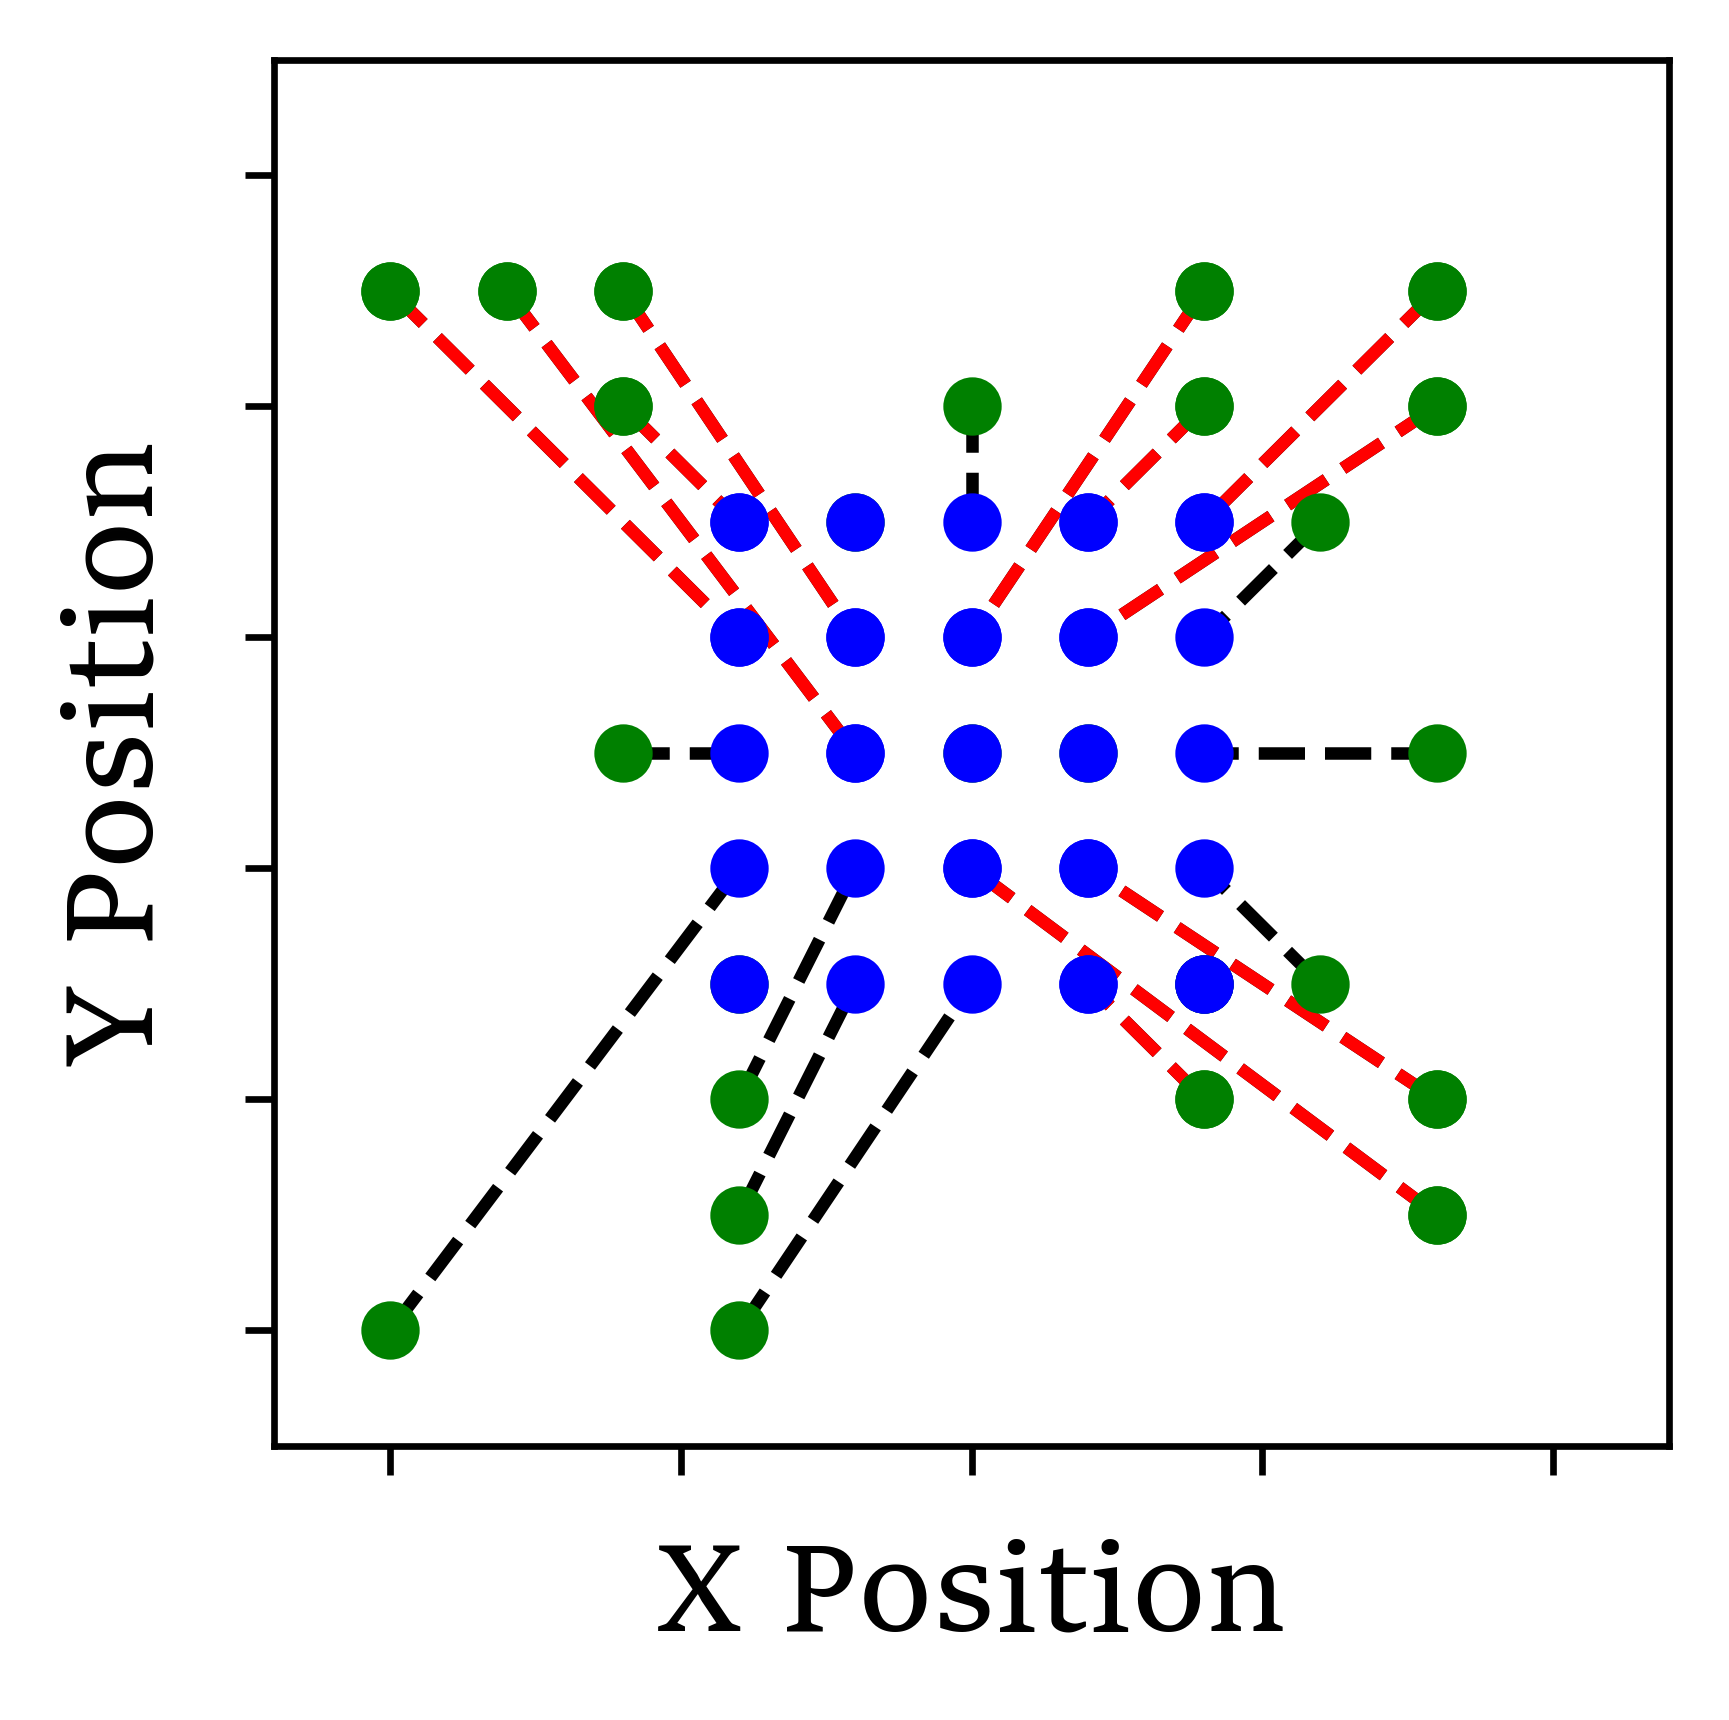

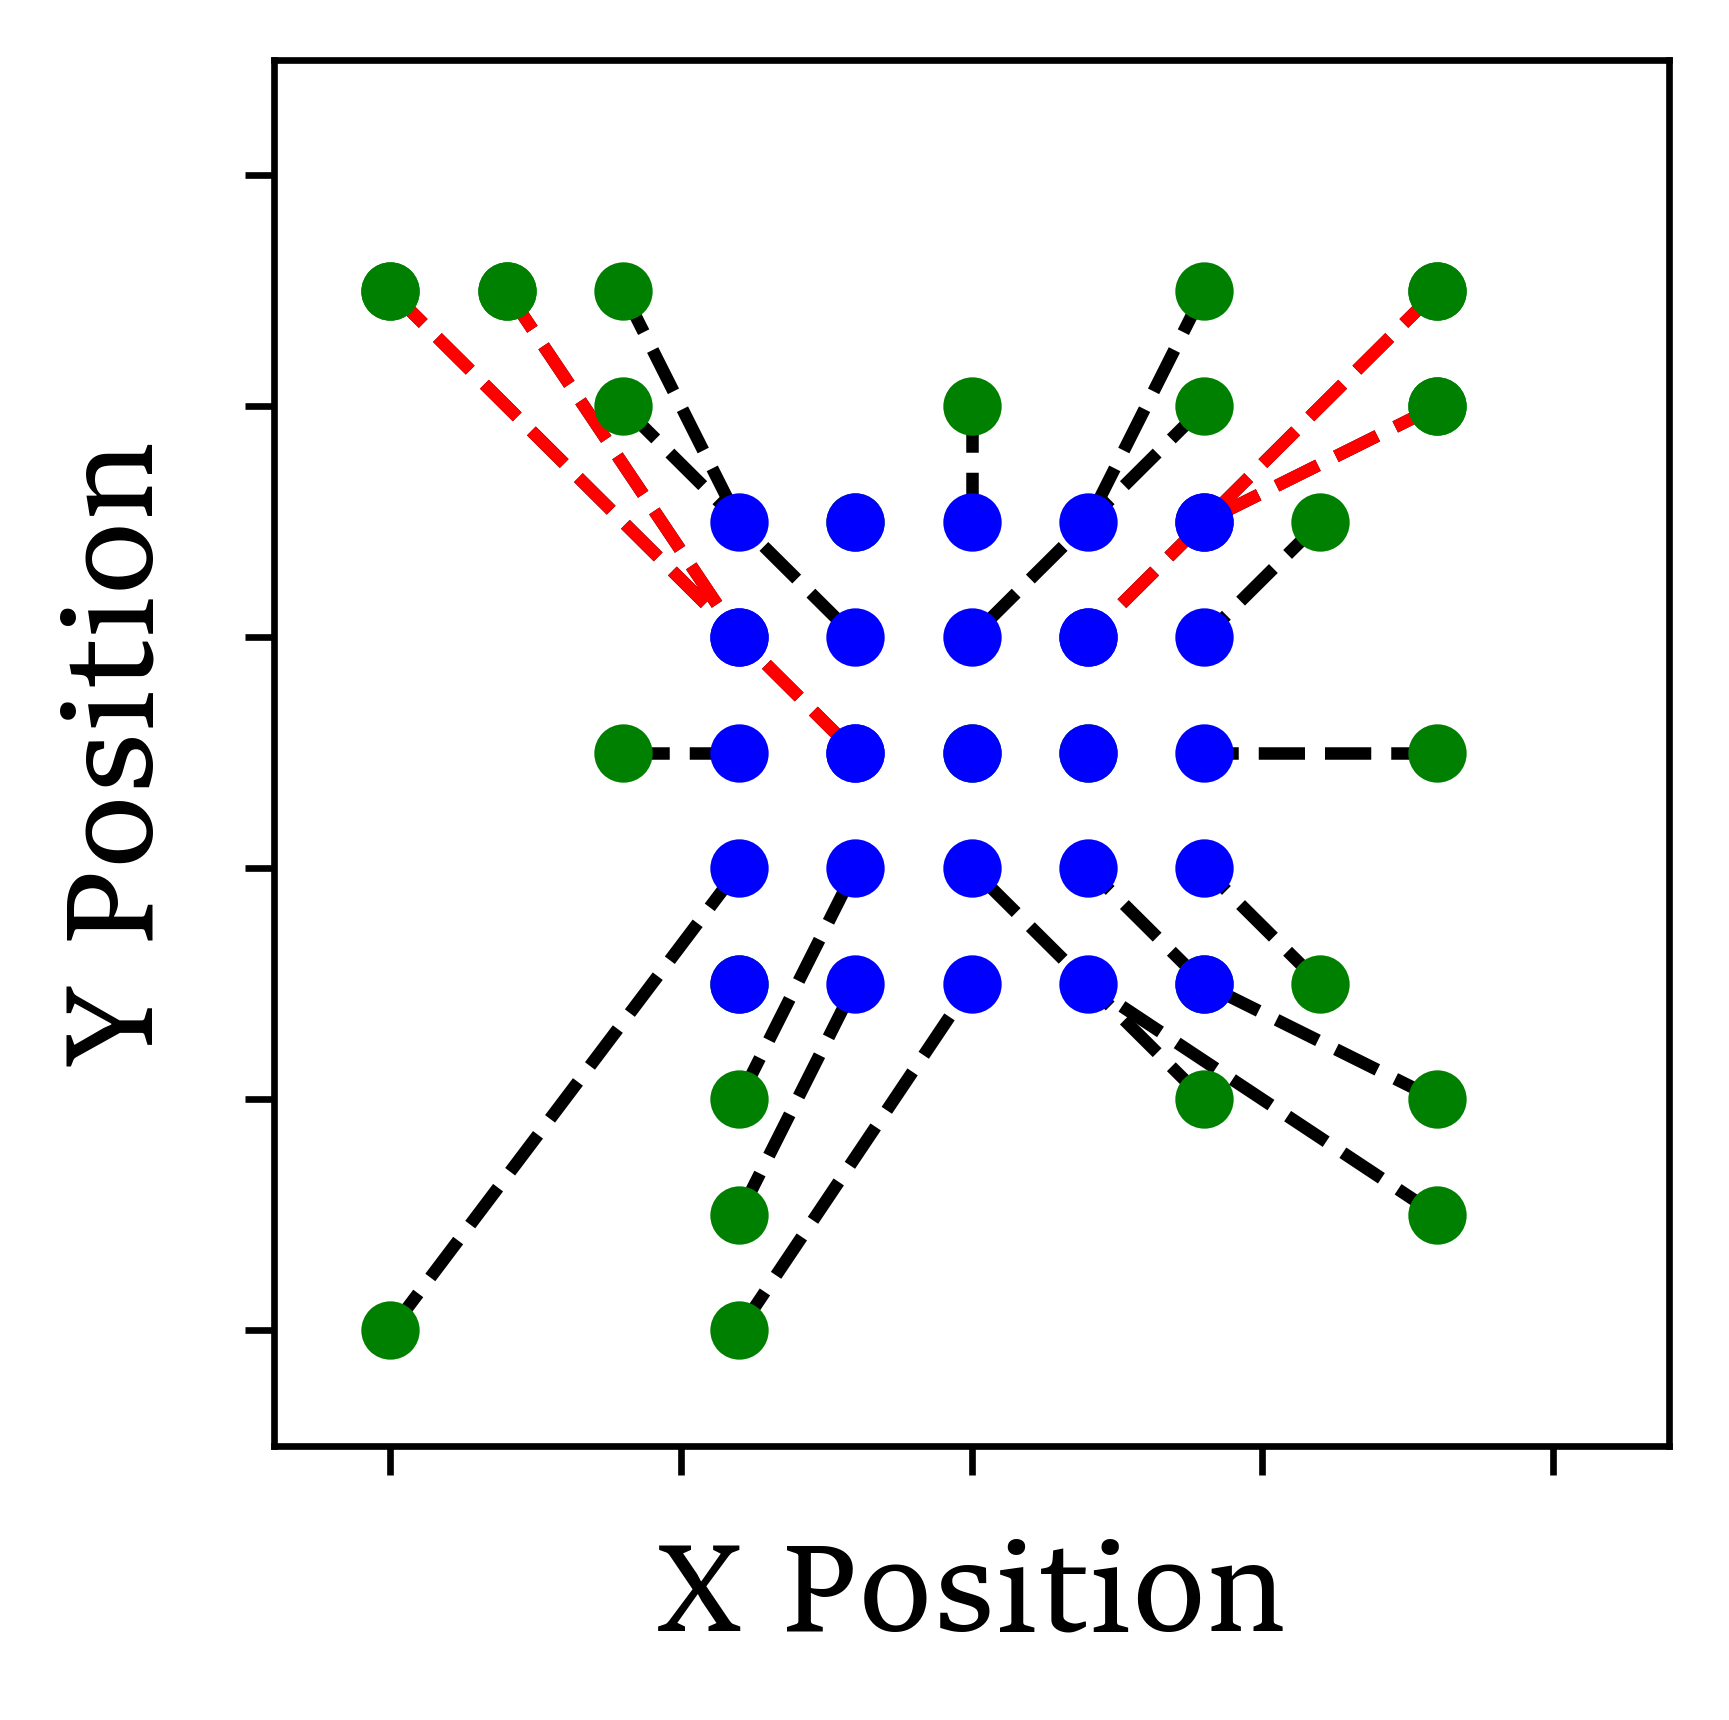

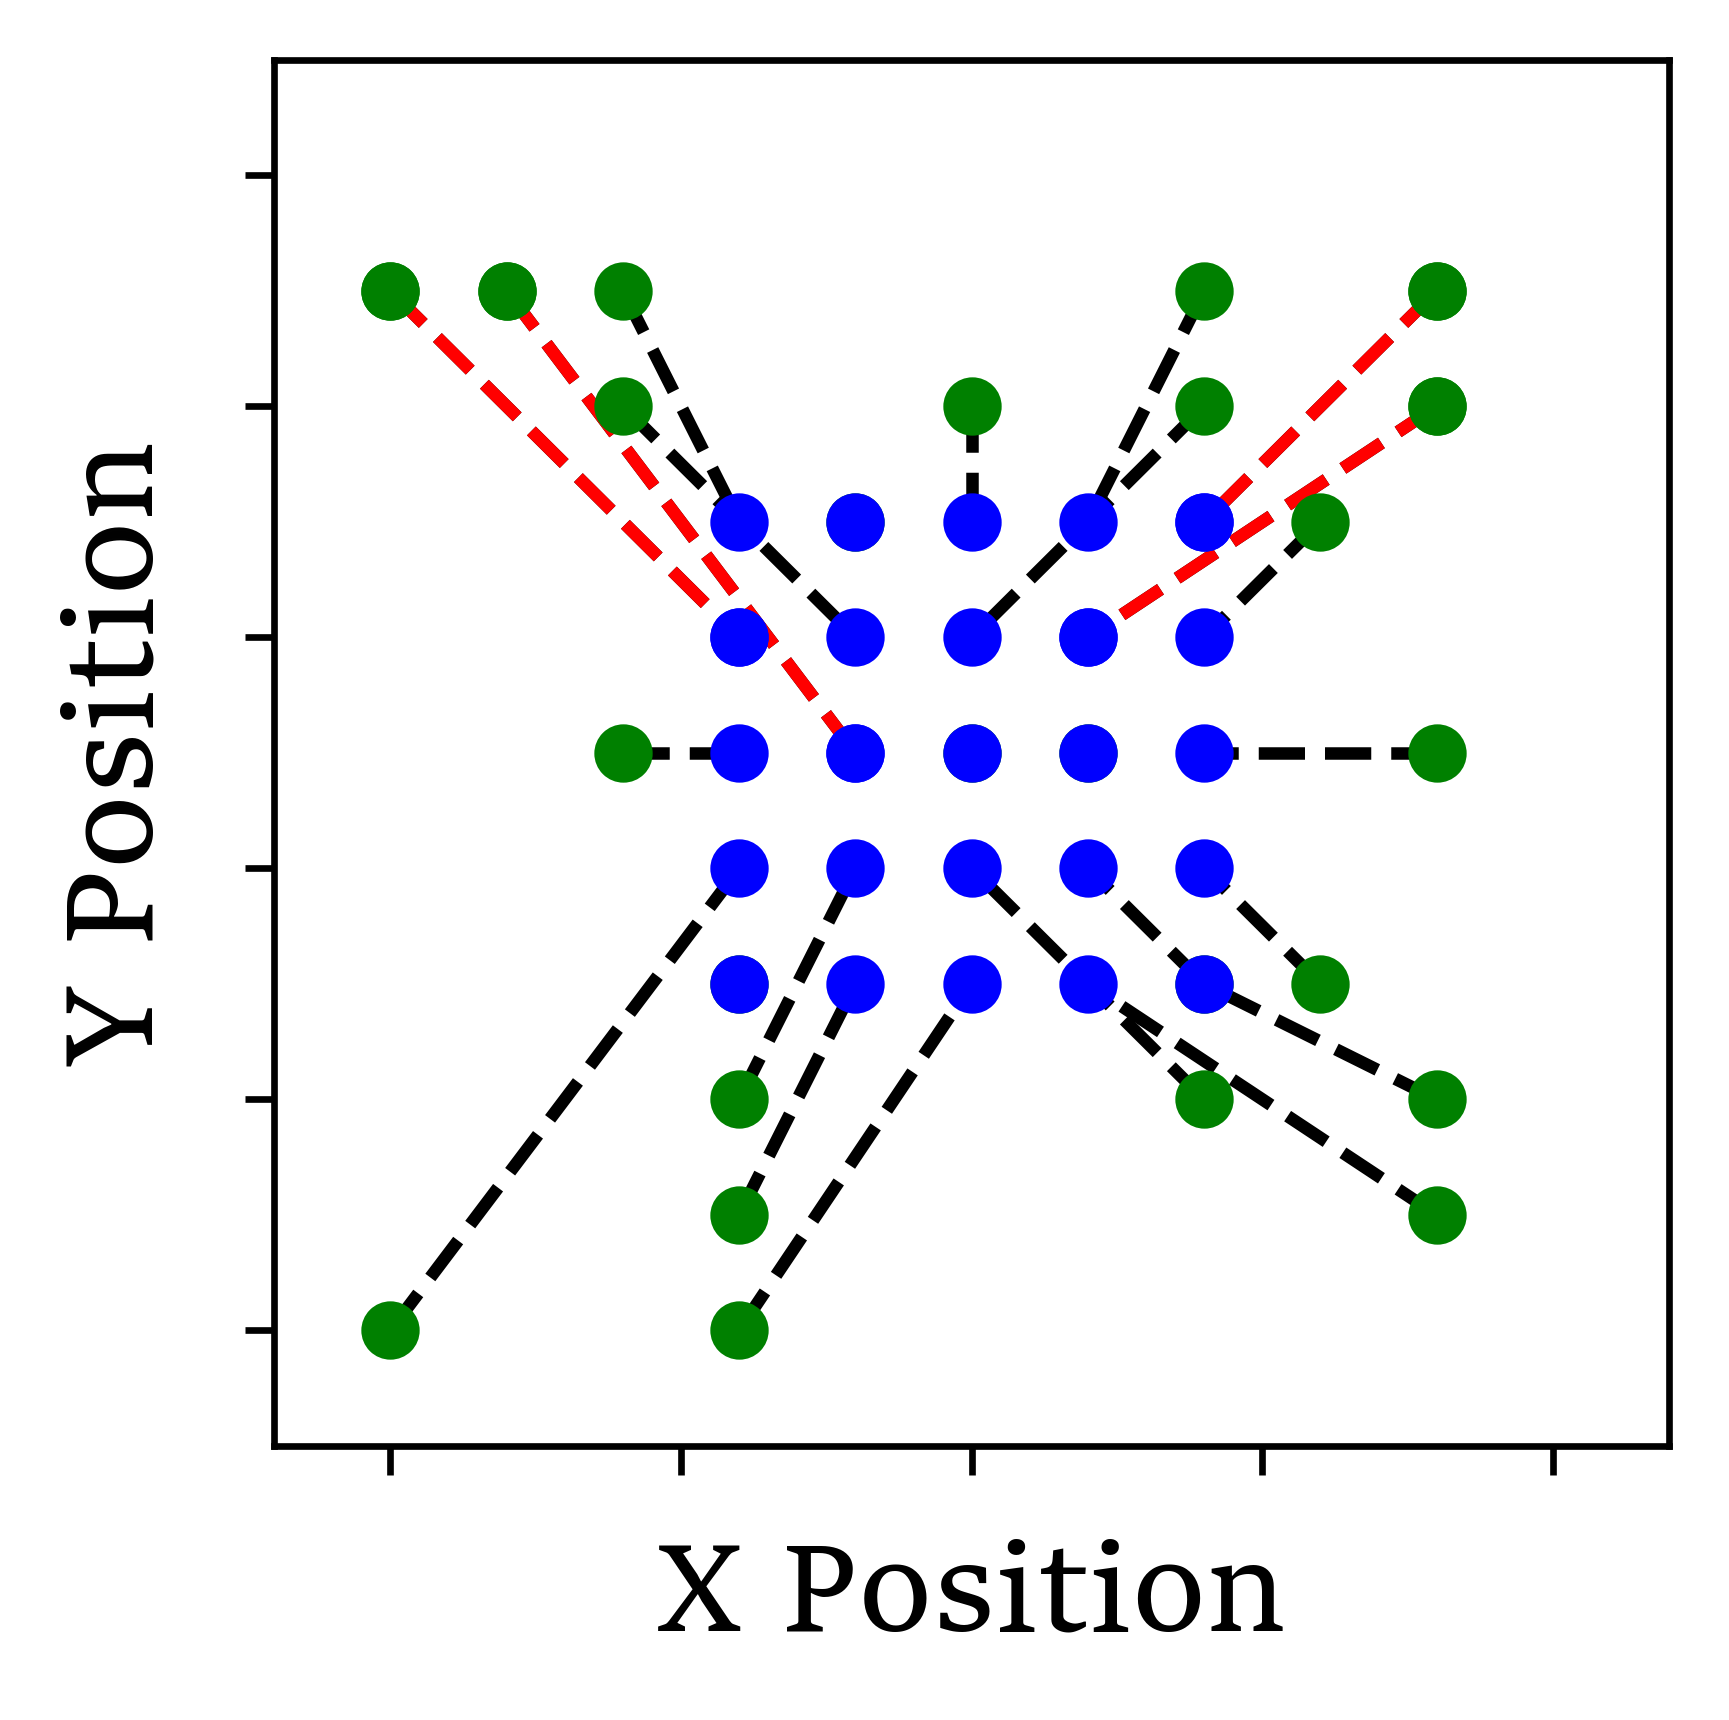

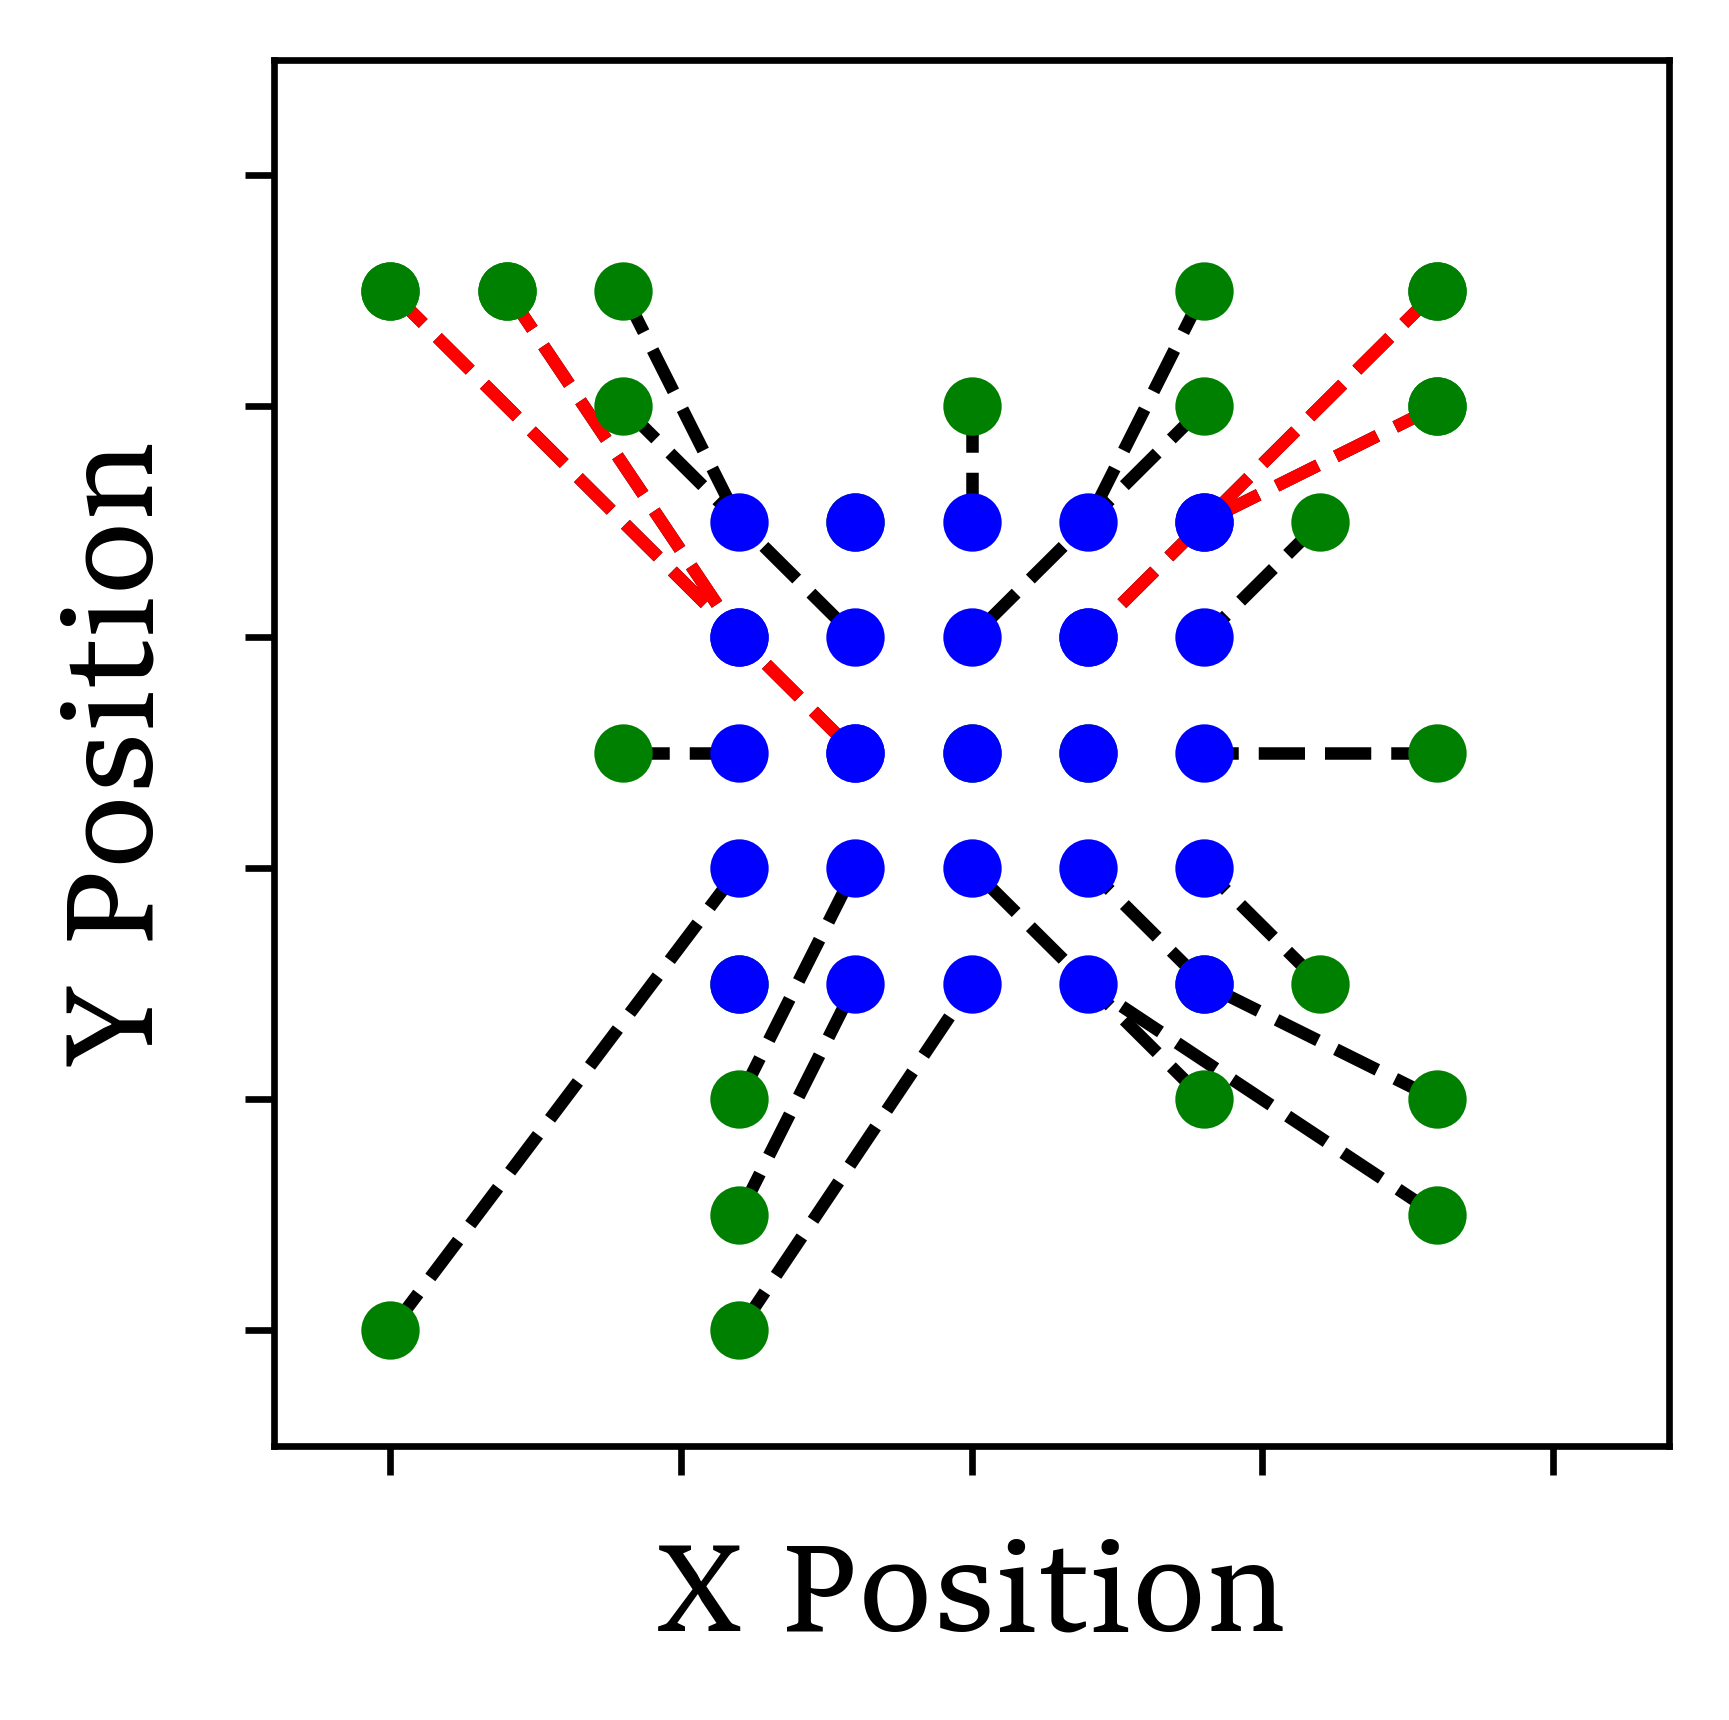

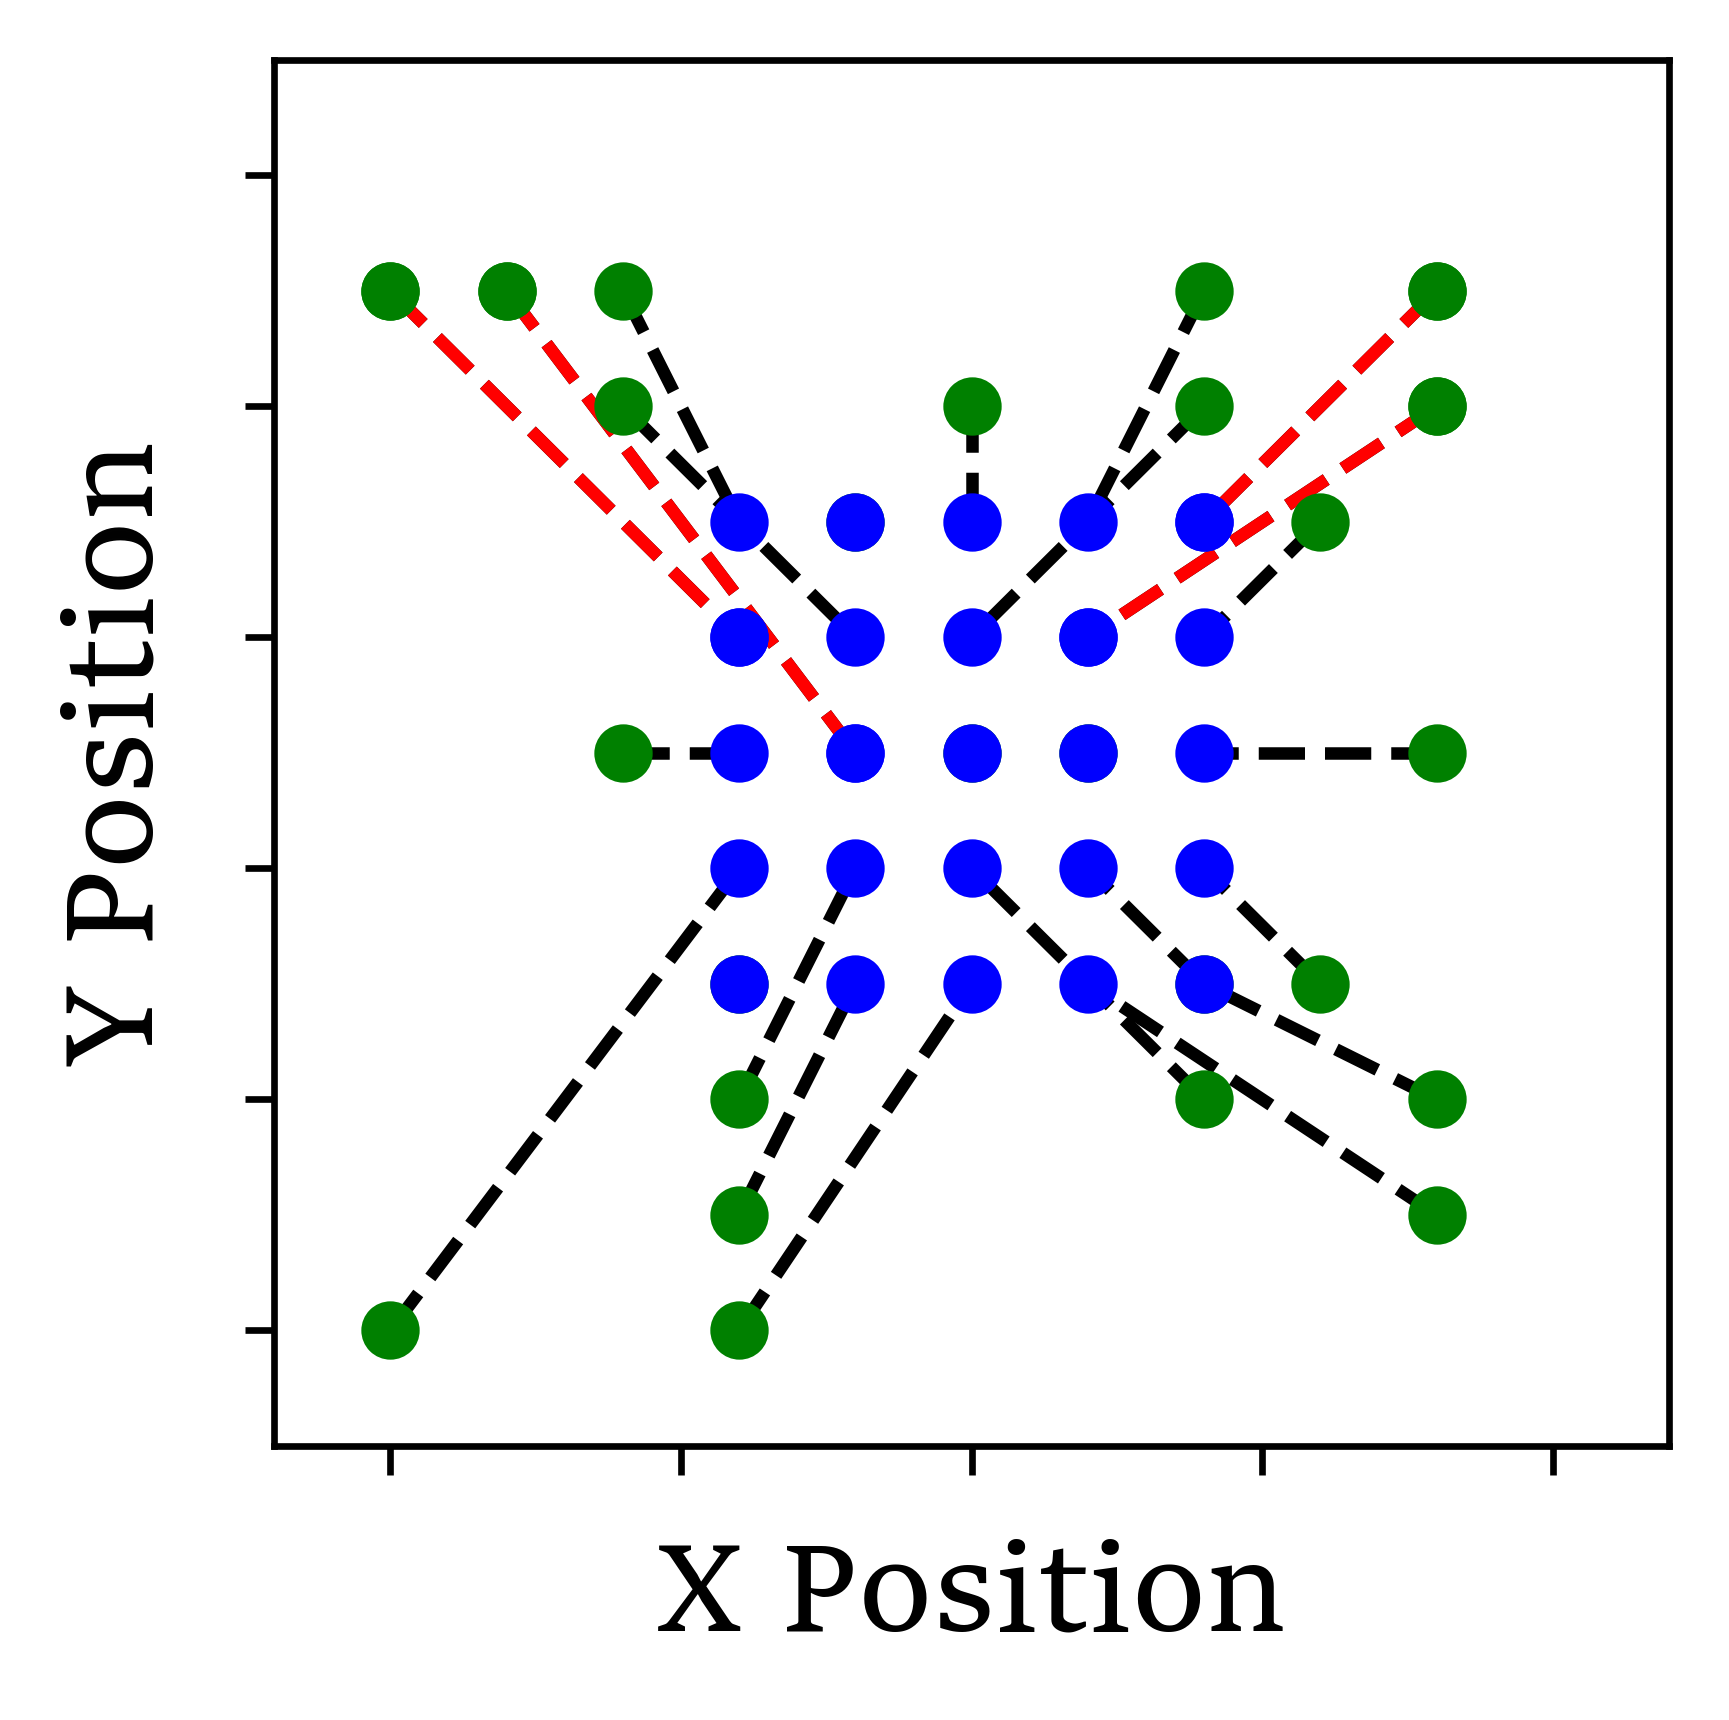

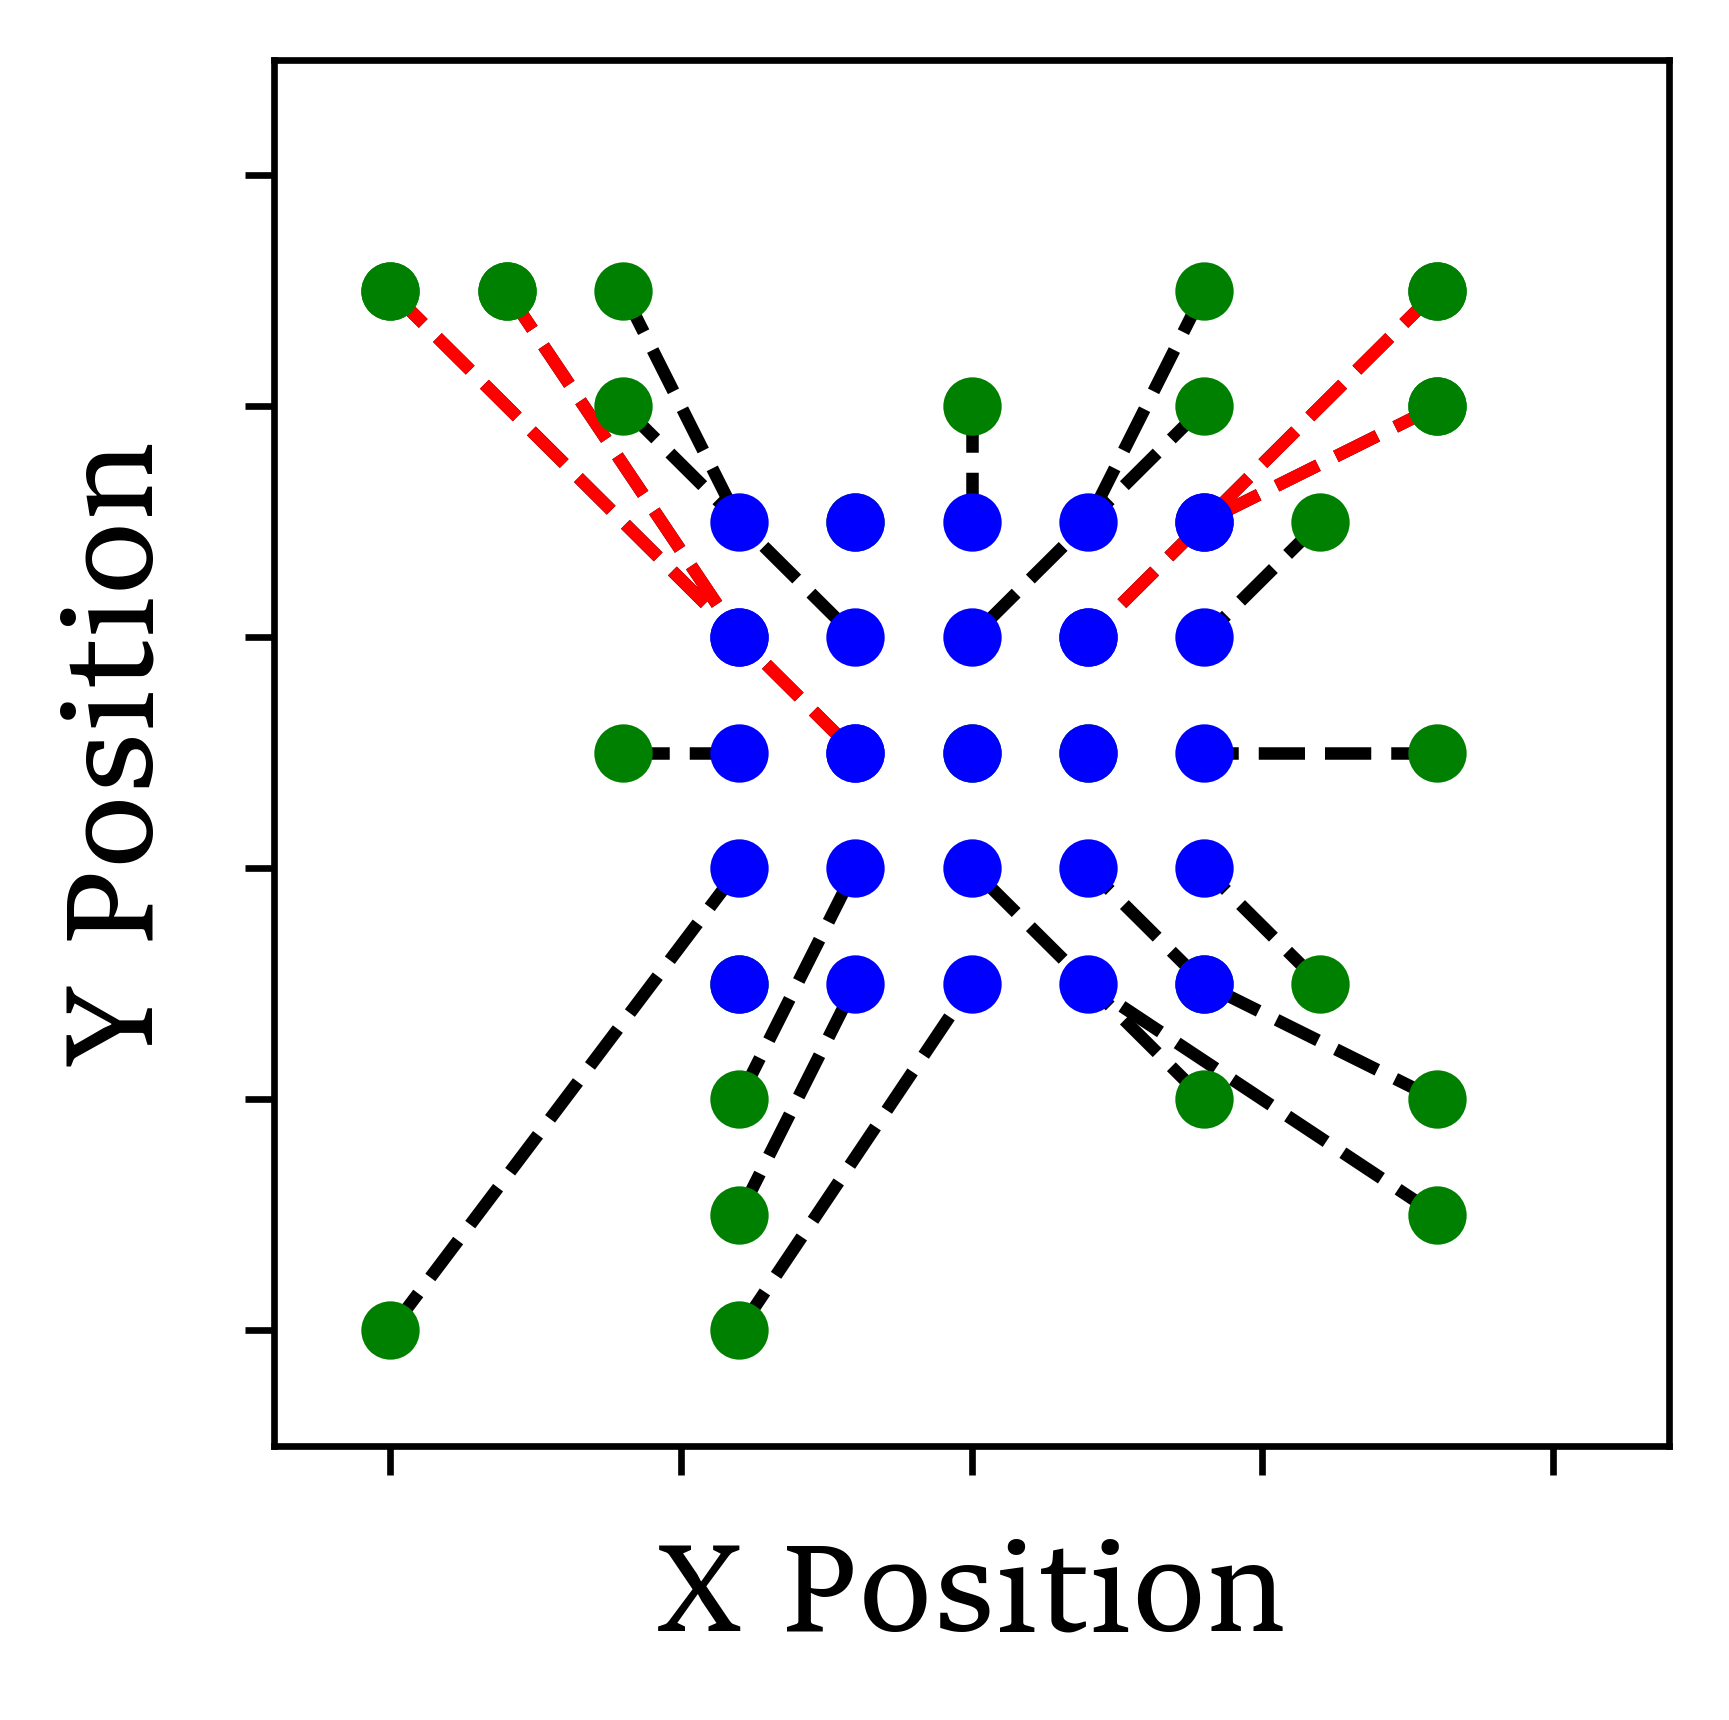

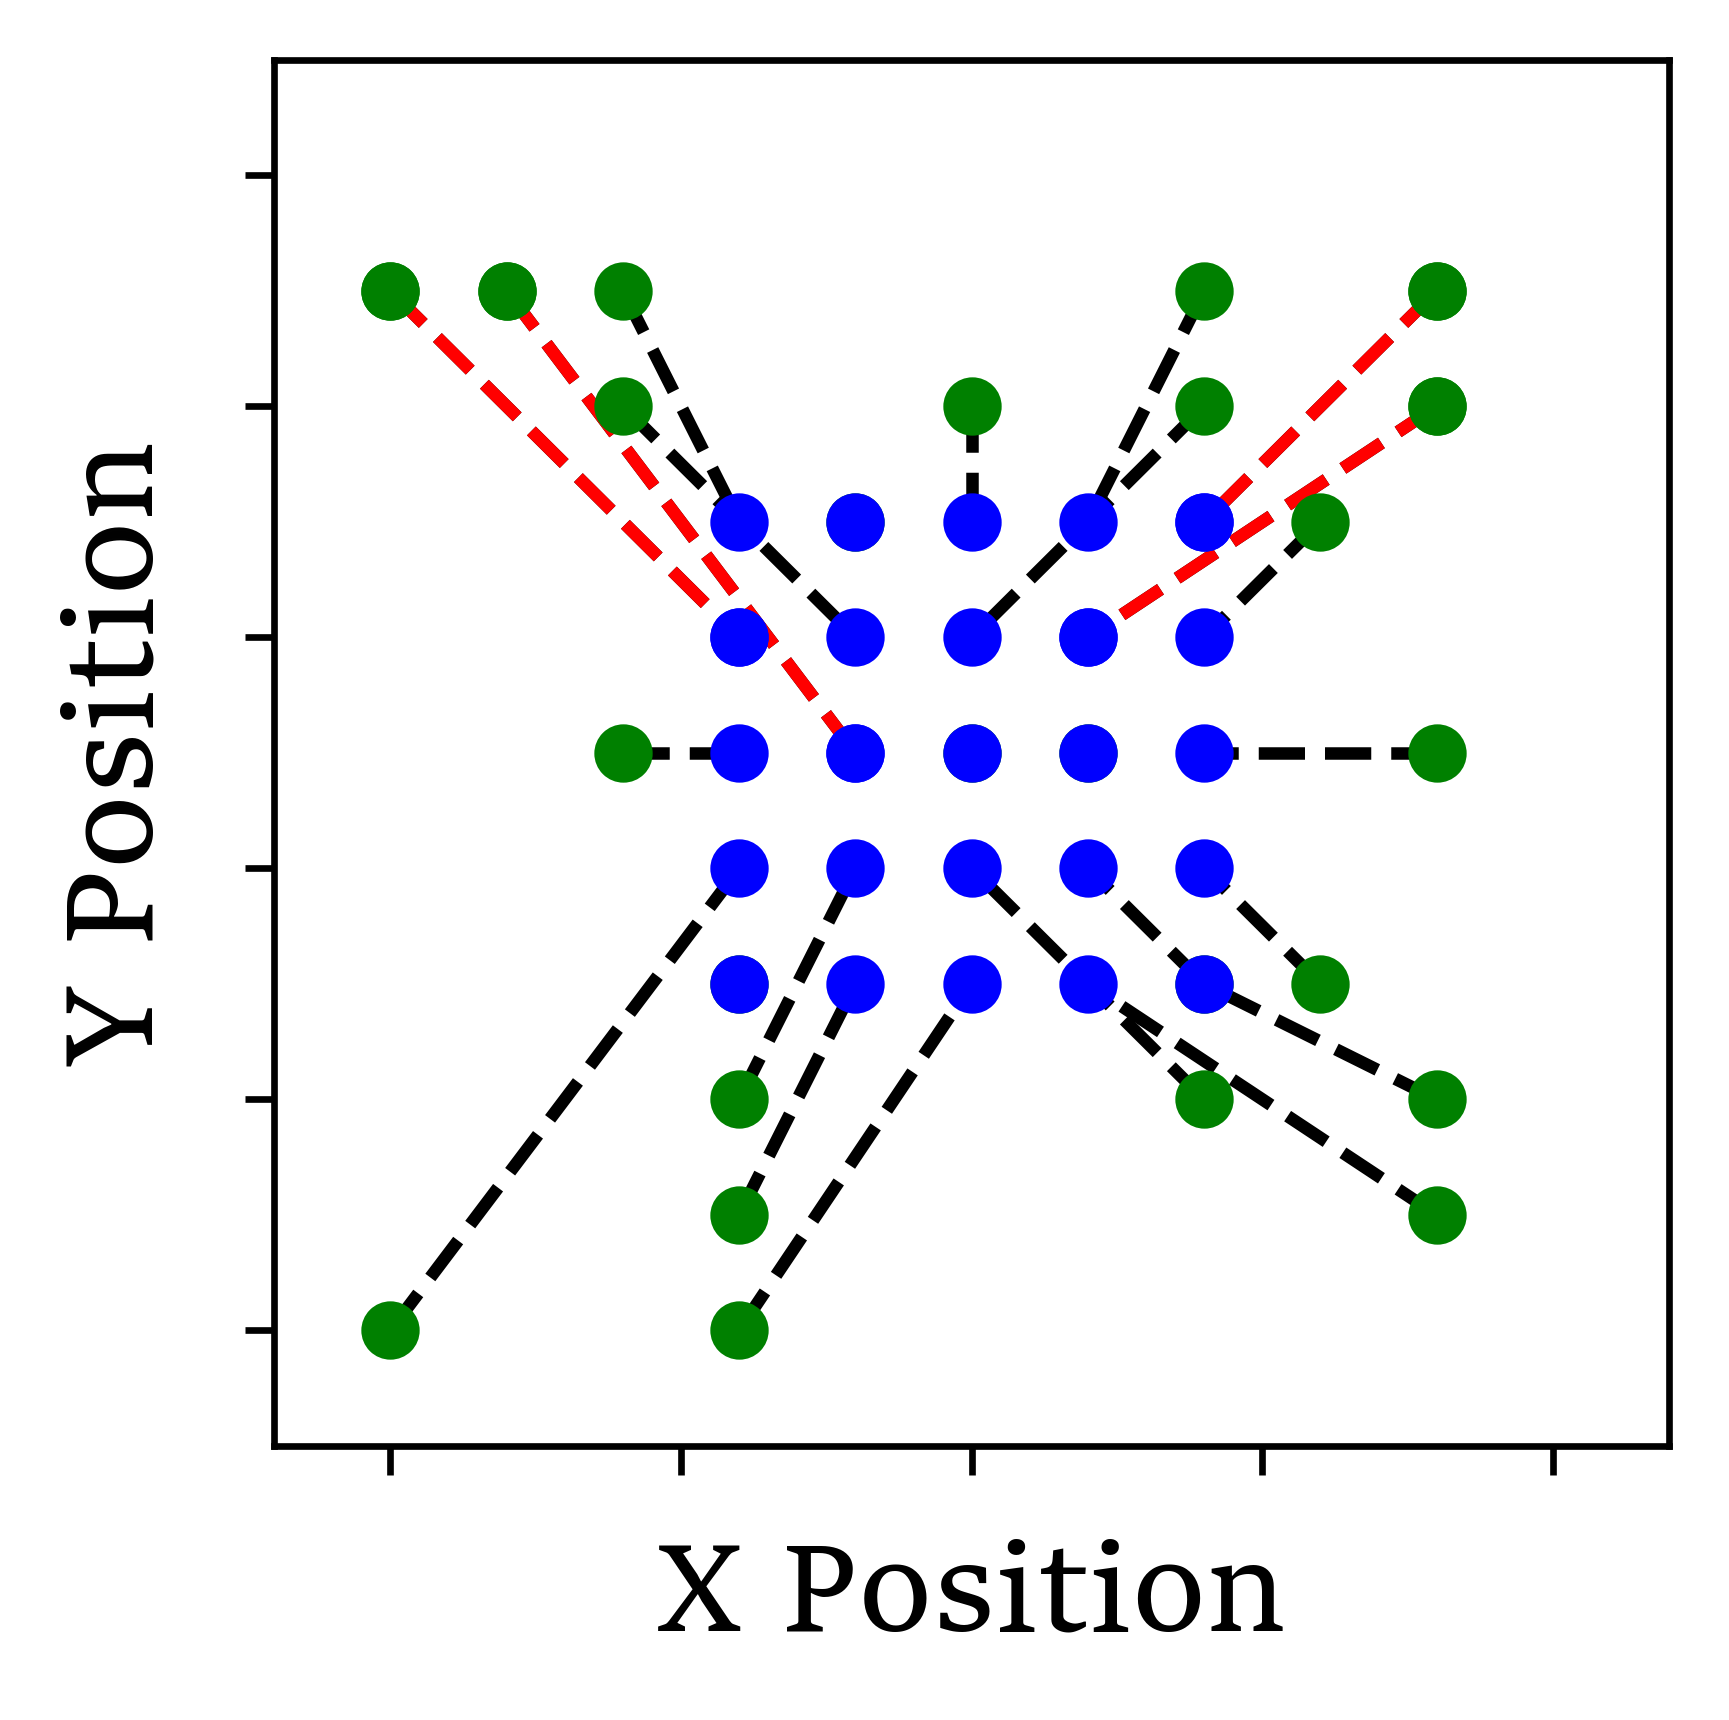

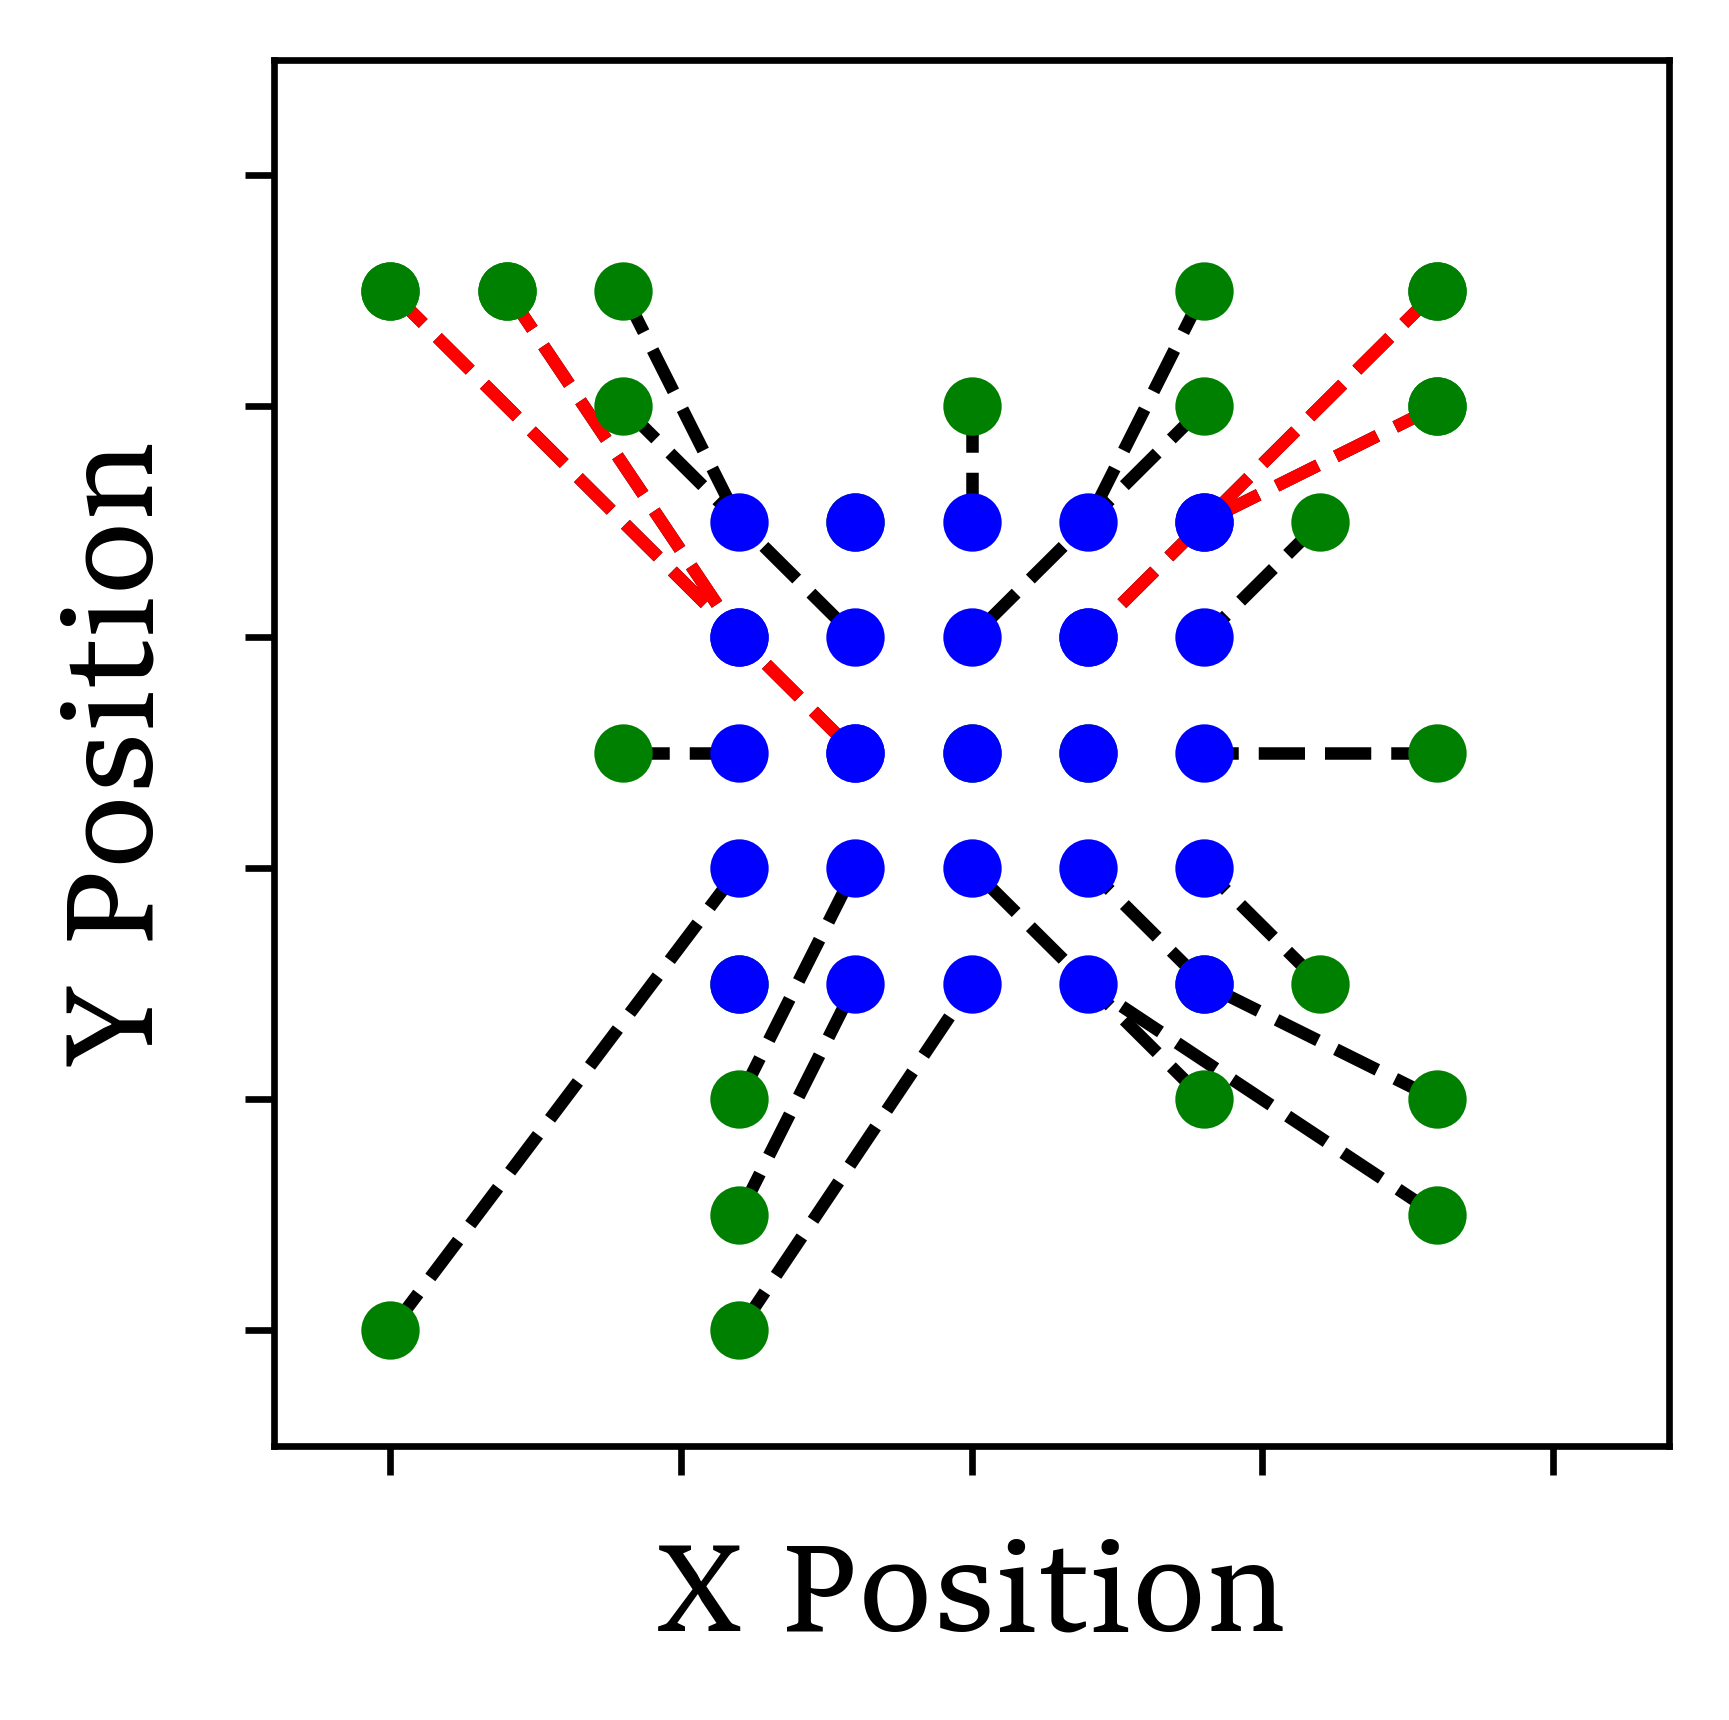

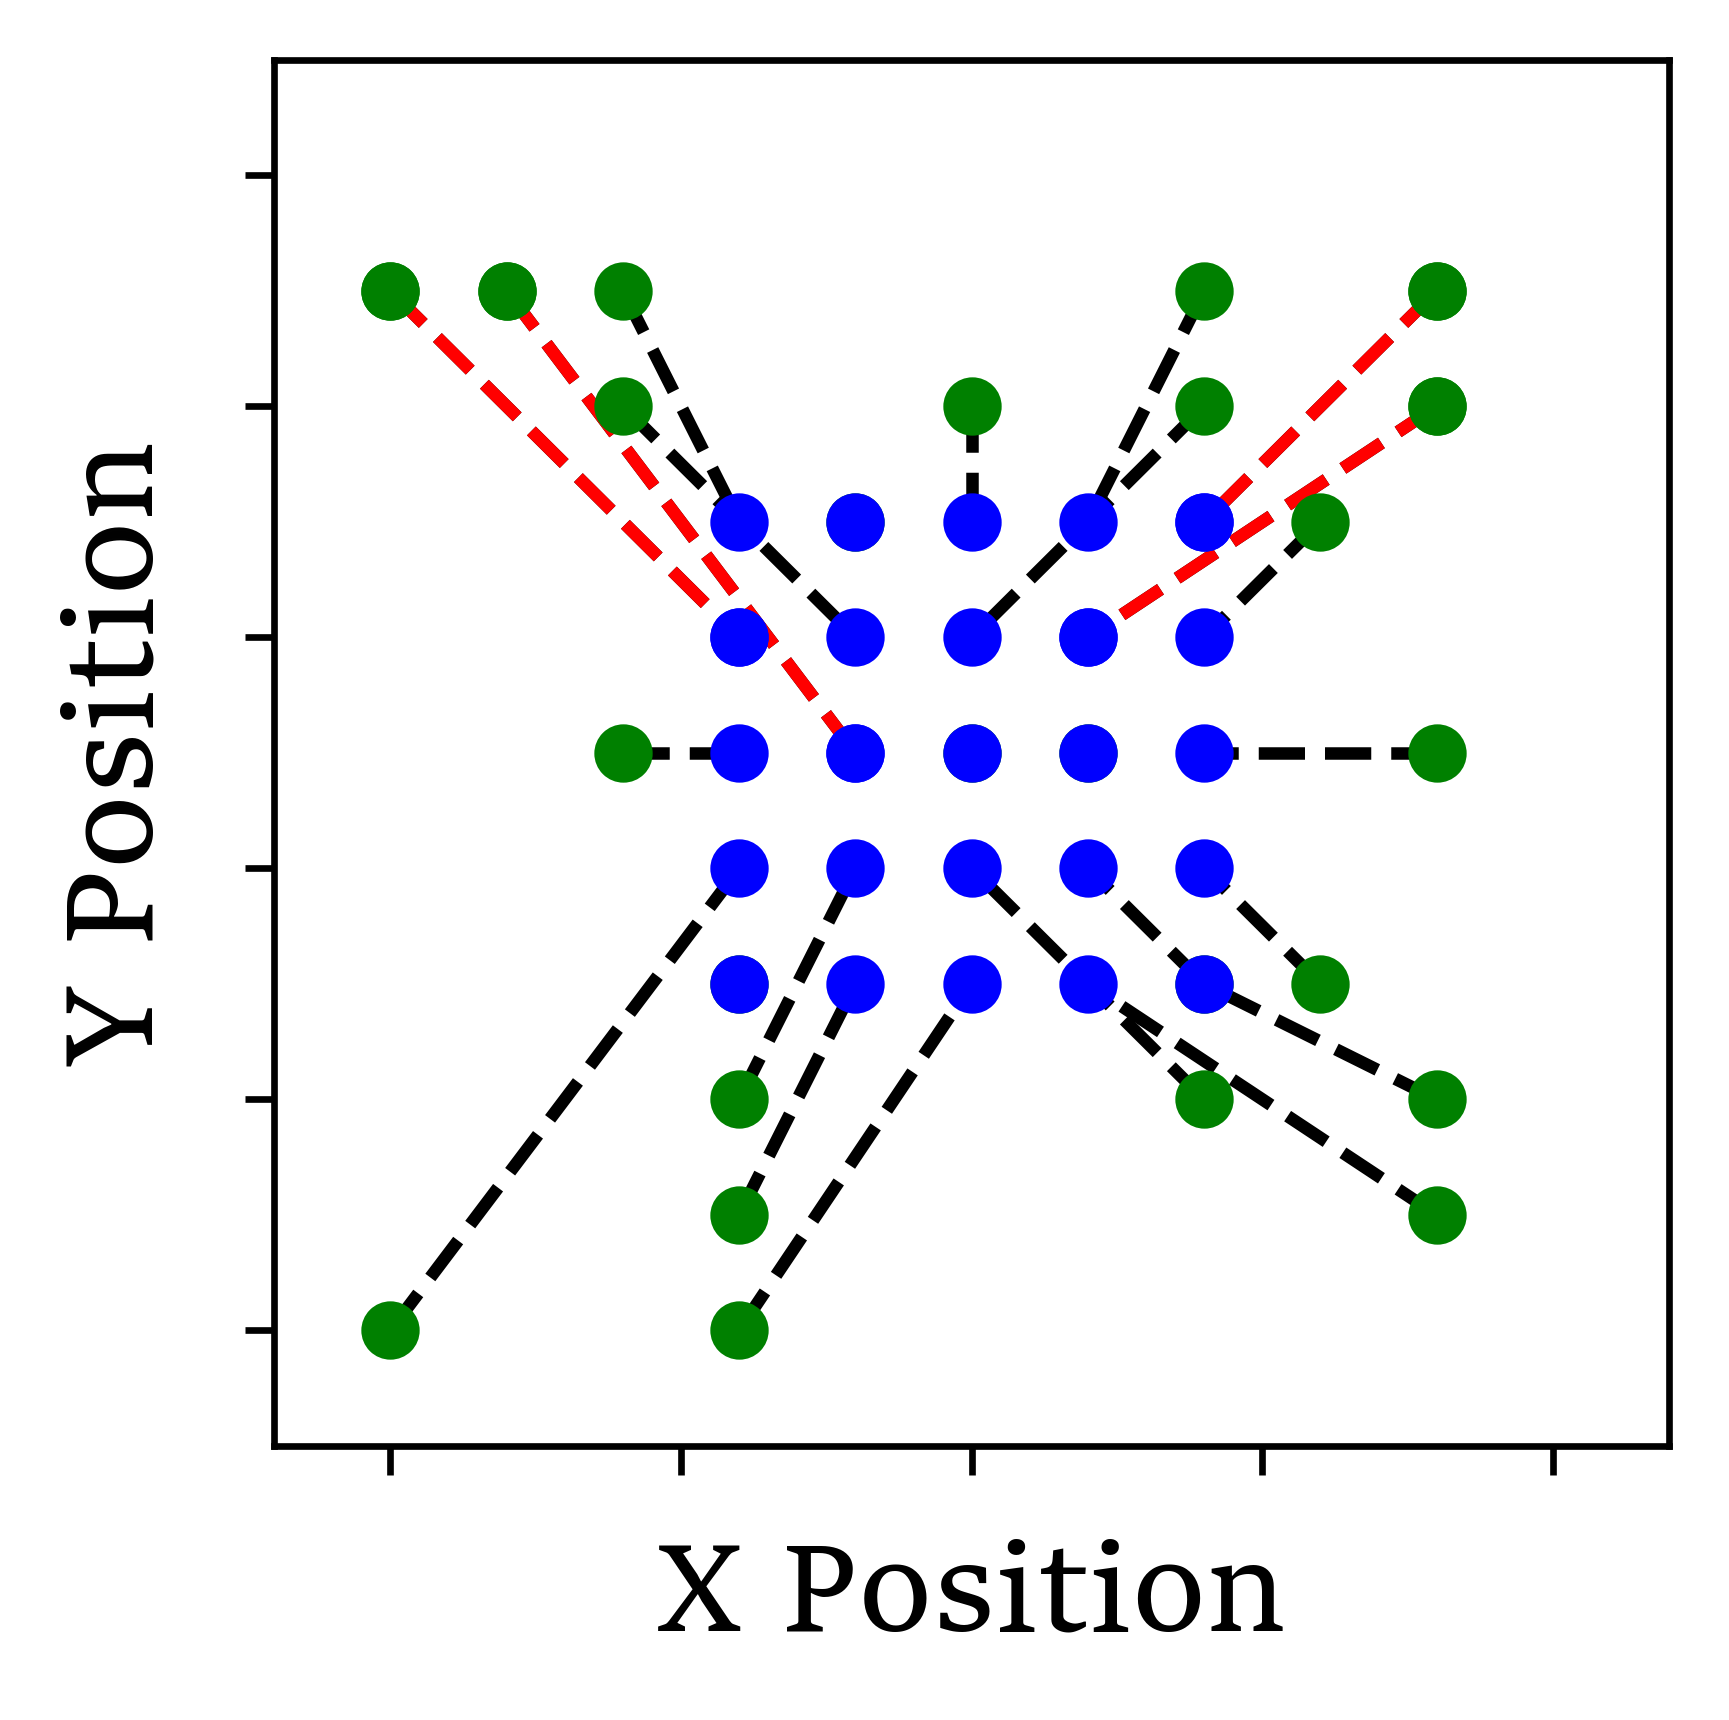

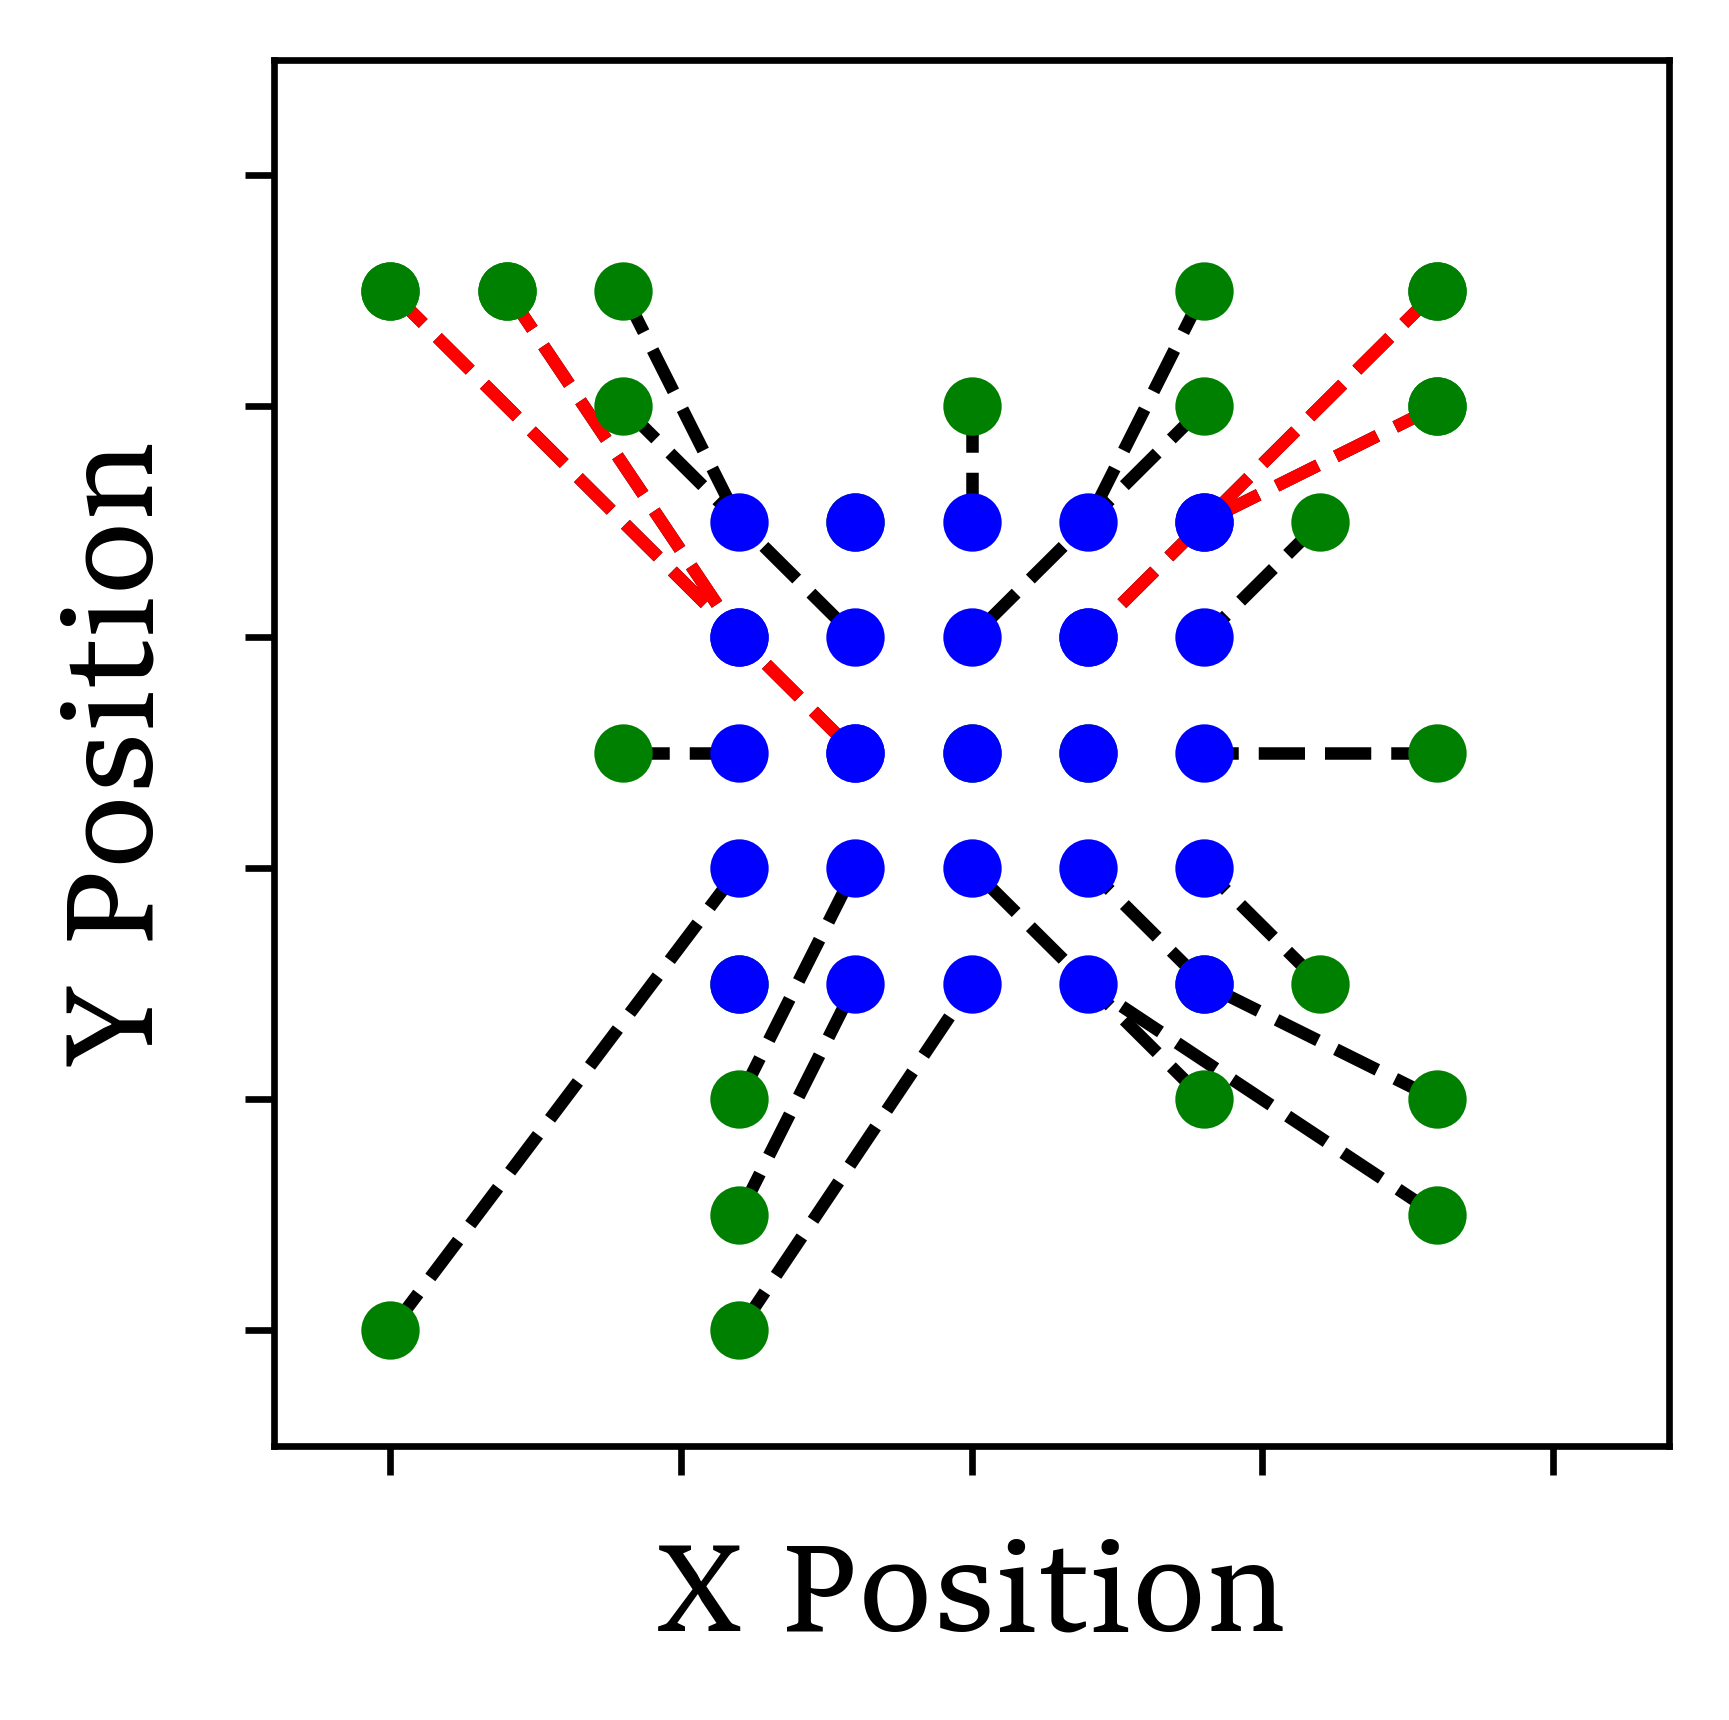

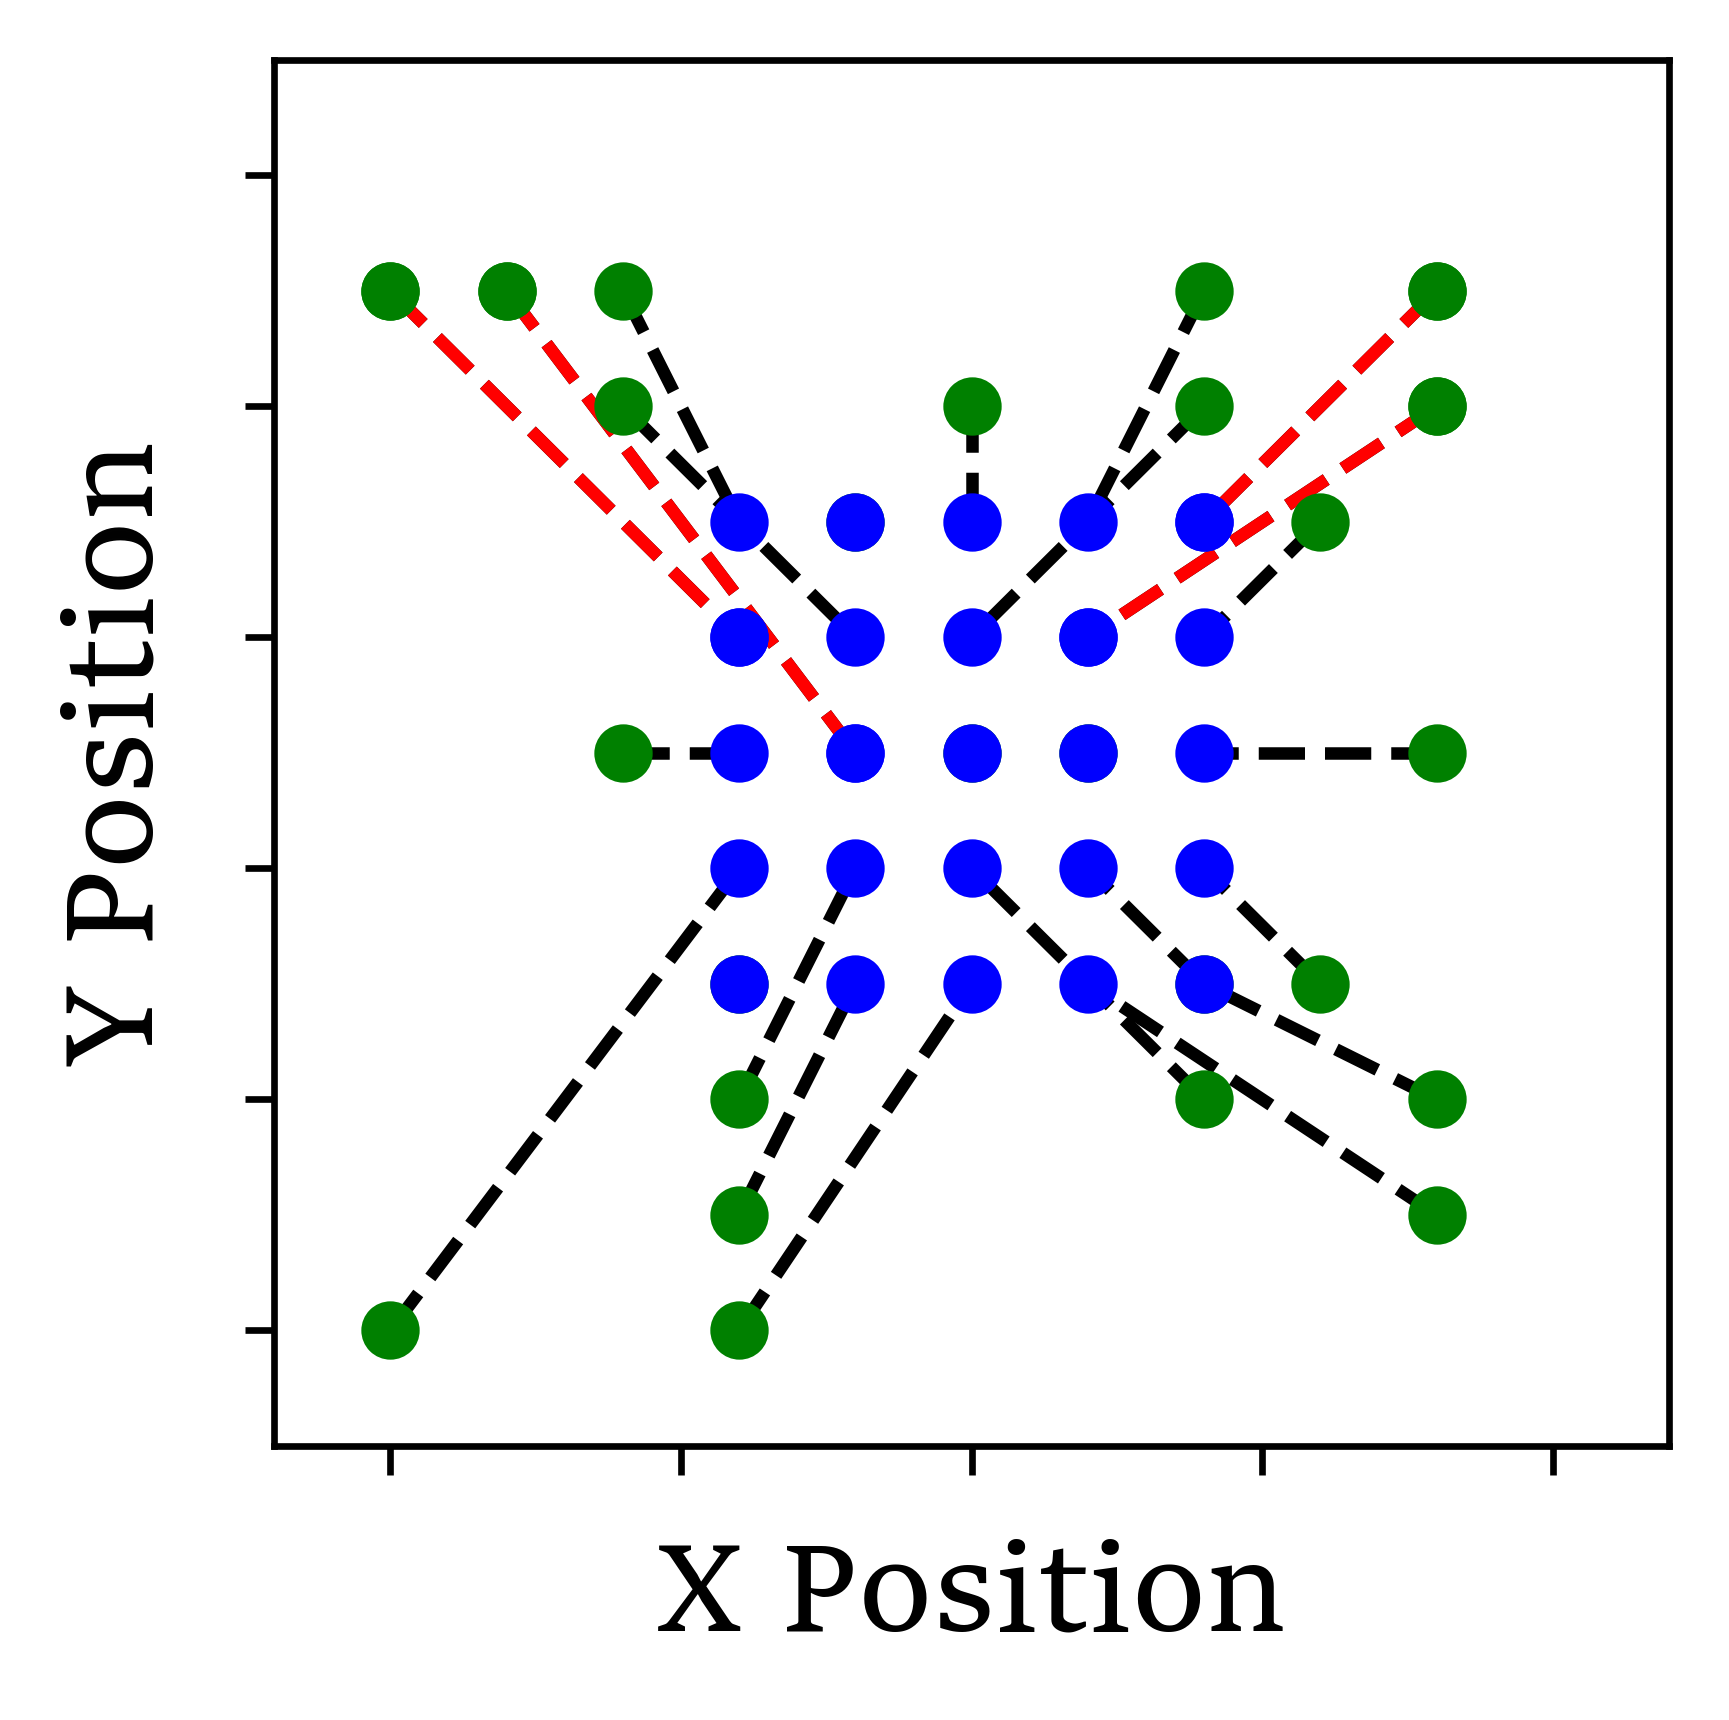

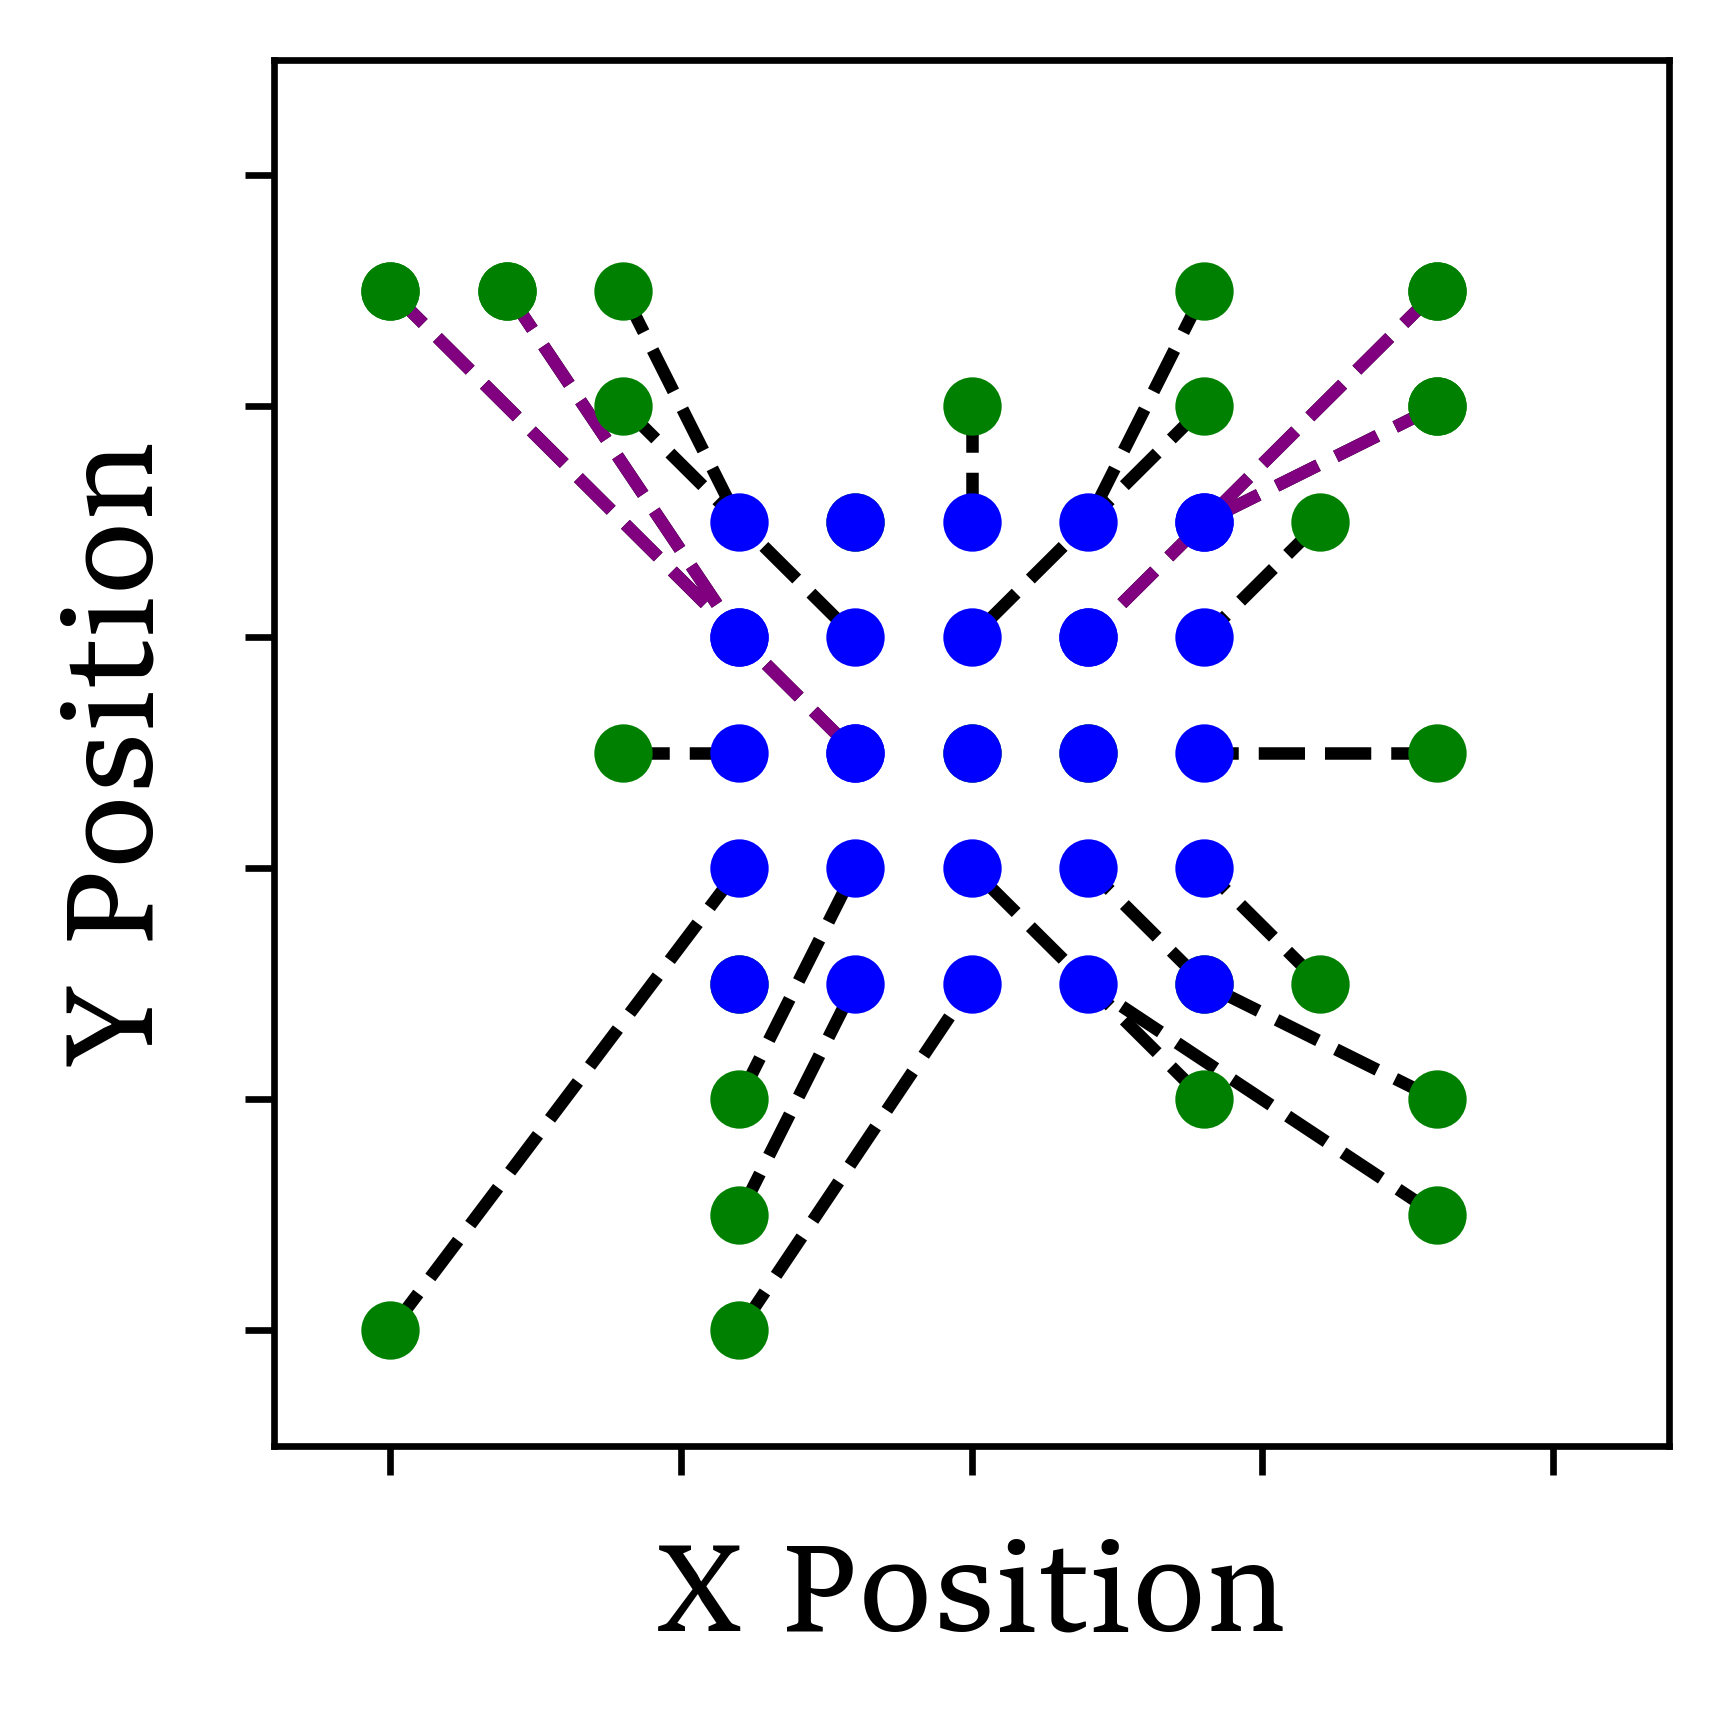

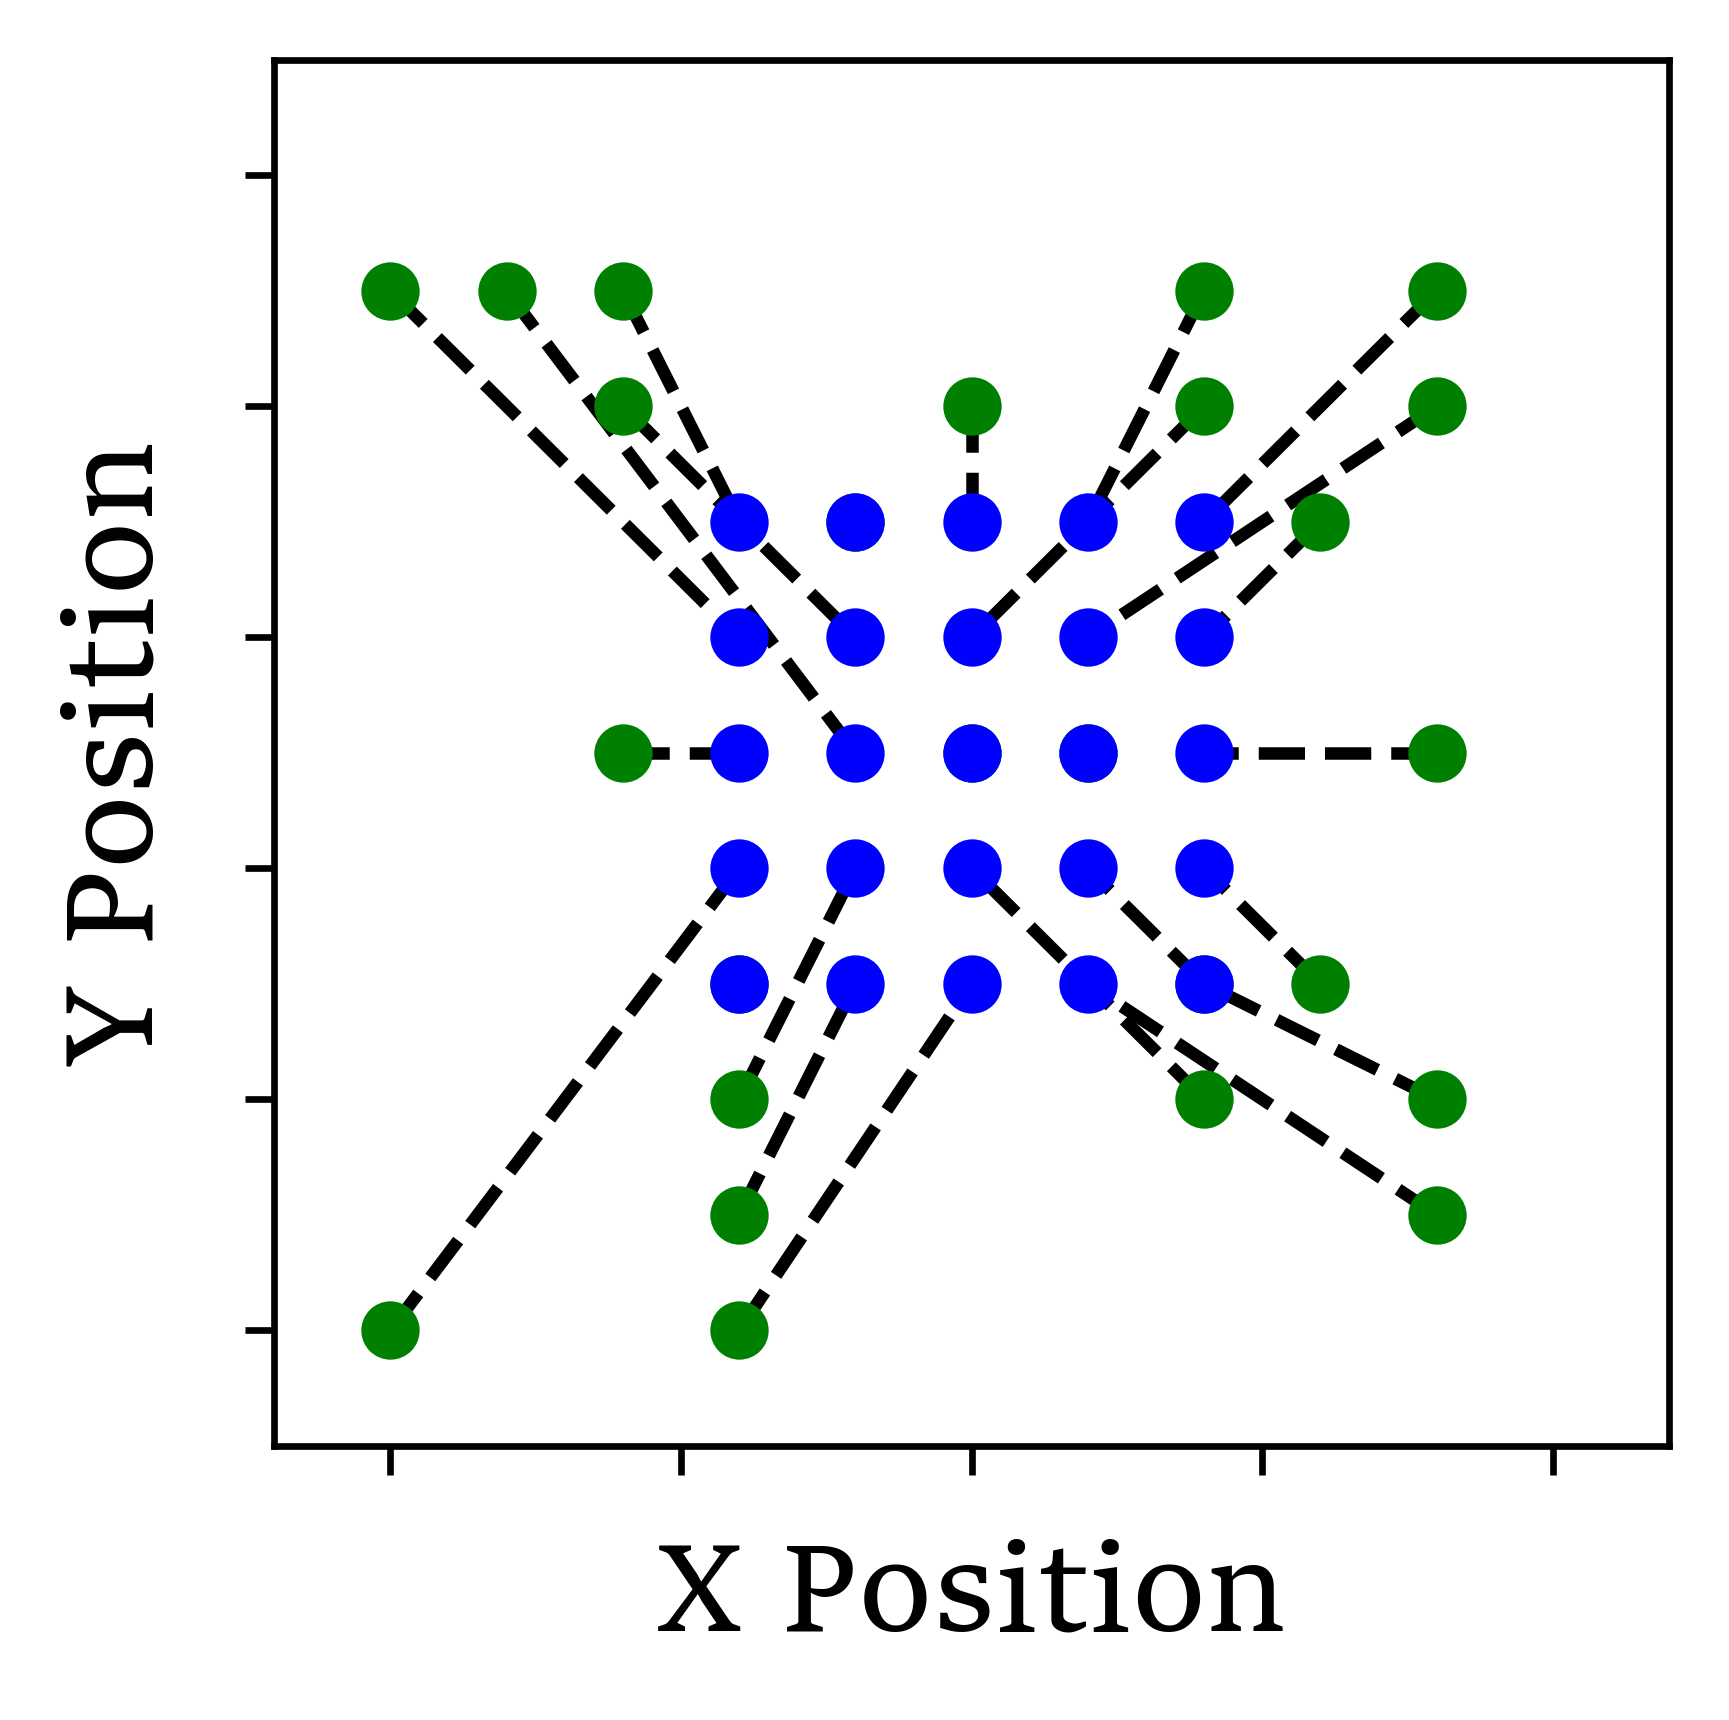

In [60]:
numspheres = 25

freqset = 23
arraysize = 5
  
startpoints = makearray(20,20,1,100,10)
random.shuffle(startpoints[:,0])
random.shuffle(startpoints[:,1])
startpoints = pd.DataFrame(startpoints)
startpoints = startpoints.drop_duplicates()
startpoints = startpoints.to_numpy()
startpoints = startpoints[:numspheres,:]

endpoints = makearray(freqset, freqset, 1, numspheres, arraysize)
endpoints = endpoints[:len(startpoints),:]

xtravellines, ytravellines, row_ind, col_ind = optimalassignment(startpoints, endpoints)
        
xtravellines, ytravellines = pathfinder(xtravellines, ytravellines, startpoints, endpoints, row_ind, col_ind, np.arange(0,(len(startpoints))))

alarm, row_ind, col_ind, counter, redrawlist = proximitycheck(xtravellines, ytravellines, row_ind, col_ind,True)

fig,ax = plt.subplots(figsize=(3,3))
for i in range(len(xtravellines)):
    lines = ax.plot(xtravellines[i], ytravellines[i],'--',zorder=1)
    plt.setp(lines, color='black')
    ax.plot(xtravellines[i][0], ytravellines[i][0], 'og',zorder=3)
    ax.plot(xtravellines[i][-1], ytravellines[i][-1], 'ob',zorder=4)

for i in redrawlist:
    lines = ax.plot(xtravellines[i], ytravellines[i],'--',zorder=2)
    plt.setp(lines, color='red')
    ax.plot(xtravellines[i][0], ytravellines[i][0], 'og',zorder=3)
    ax.plot(xtravellines[i][-1], ytravellines[i][-1], 'ob',zorder=4)

ax.set_xlim([19, 31])
ax.set_ylim([19, 31])
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

if alarm == True:
    xtravellines, ytravellines, row_ind, col_ind, counter, trieddelay, delaycounter, redrawlist = doublecheck(alarm, xtravellines, ytravellines, row_ind, col_ind, startpoints, endpoints, redrawlist)
   
fig,ax = plt.subplots(figsize=(3,3))
for i in range(len(xtravellines)):
    lines = ax.plot(xtravellines[i], ytravellines[i],'--',zorder=1)
    plt.setp(lines, color='black')
    ax.plot(xtravellines[i][0], ytravellines[i][0], 'og',zorder=3)
    ax.plot(xtravellines[i][-1], ytravellines[i][-1], 'ob',zorder=4)

for i in redrawlist:
    lines = ax.plot(xtravellines[i], ytravellines[i],'--',zorder=2)
    plt.setp(lines, color='red')
    ax.plot(xtravellines[i][0], ytravellines[i][0], 'og',zorder=3)
    ax.plot(xtravellines[i][-1], ytravellines[i][-1], 'ob',zorder=4)

ax.set_xlim([19, 31])
ax.set_ylim([19, 31])
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show() 
